In [107]:
import pandas as pd
import numpy as np
import seaborn as sns
import graphviz
# import sompy
import matplotlib.pyplot as plt
import umap.umap_ as UMAP
import plotly.express as px # for data visualization

from collections import Counter
from datetime import datetime
from math import ceil
from kneed import KneeLocator

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from scipy.cluster.hierarchy import dendrogram

from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

from matplotlib.patches import RegularPolygon, Ellipse
from matplotlib import cm, colorbar
from matplotlib import colors as mpl_colors
from matplotlib import __version__ as mplver
from matplotlib.lines import Line2D

from mpl_toolkits.axes_grid1 import make_axes_locatable

from yellowbrick.cluster import KElbowVisualizer

from kmodes.kprototypes import KPrototypes

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# from pandas_profiling import ProfileReport
# import logging
# logging.getLogger('matplotlib.font_manager').disabled = True

## 1. Data Understanding

In [108]:
df = pd.read_sas('a2z_insurance.sas7bdat')
df.set_index('CustID', inplace=True)

In [109]:
df.head(5)

FirstPolYear  BirthYear             EducDeg  MonthSal  GeoLivArea  \
CustID                                                                      
1.0           1985.0     1982.0  b'2 - High School'    2177.0         1.0   
2.0           1981.0     1995.0  b'2 - High School'     677.0         4.0   
3.0           1991.0     1970.0        b'1 - Basic'    2277.0         3.0   
4.0           1990.0     1981.0      b'3 - BSc/MSc'    1099.0         4.0   
5.0           1986.0     1973.0      b'3 - BSc/MSc'    1763.0         4.0   

        Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  \
CustID                                                               
1.0          1.0      380.97        0.39     375.85          79.45   
2.0          1.0     -131.13        1.12      77.46         416.20   
3.0          0.0      504.67        0.28     206.15         224.50   
4.0          1.0      -16.99        0.99     182.48          43.35   
5.0          1.0       35.23        0.90     338.62          47.80   

        PremHealth  PremLife  PremWork  
CustID                                  
1.0         146.36     47.01     16.89  
2.0         116.69    194.48    106.13  
3.0         124.58     86.35     99.02  
4.0         311.17     35.34     28.34  
5.0         182.59     18.78     41.45

In [110]:
df.shape

(10296, 13)

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 10296 entries, 1.0 to 10296.0
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FirstPolYear   10266 non-null  float64
 1   BirthYear      10279 non-null  float64
 2   EducDeg        10279 non-null  object 
 3   MonthSal       10260 non-null  float64
 4   GeoLivArea     10295 non-null  float64
 5   Children       10275 non-null  float64
 6   CustMonVal     10296 non-null  float64
 7   ClaimsRate     10296 non-null  float64
 8   PremMotor      10262 non-null  float64
 9   PremHousehold  10296 non-null  float64
 10  PremHealth     10253 non-null  float64
 11  PremLife       10192 non-null  float64
 12  PremWork       10210 non-null  float64
dtypes: float64(12), object(1)
memory usage: 1.1+ MB


In [112]:
df.describe().T

count         mean          std        min      25%      50%  \
FirstPolYear   10266.0  1991.062634   511.267913    1974.00  1980.00  1986.00   
BirthYear      10279.0  1968.007783    19.709476    1028.00  1953.00  1968.00   
MonthSal       10260.0  2506.667057  1157.449634     333.00  1706.00  2501.50   
GeoLivArea     10295.0     2.709859     1.266291       1.00     1.00     3.00   
Children       10275.0     0.706764     0.455268       0.00     0.00     1.00   
CustMonVal     10296.0   177.892605  1945.811505 -165680.42    -9.44   186.87   
ClaimsRate     10296.0     0.742772     2.916964       0.00     0.39     0.72   
PremMotor      10262.0   300.470252   211.914997      -4.11   190.59   298.61   
PremHousehold  10296.0   210.431192   352.595984     -75.00    49.45   132.80   
PremHealth     10253.0   171.580833   296.405976      -2.11   111.80   162.81   
PremLife       10192.0    41.855782    47.480632      -7.00     9.89    25.56   
PremWork       10210.0    41.277514    51.513572     -12.00    10.67    25.67   

                     75%       max  
FirstPolYear   1992.0000  53784.00  
BirthYear      1983.0000   2001.00  
MonthSal       3290.2500  55215.00  
GeoLivArea        4.0000      4.00  
Children          1.0000      1.00  
CustMonVal      399.7775  11875.89  
ClaimsRate        0.9800    256.20  
PremMotor       408.3000  11604.42  
PremHousehold   290.0500  25048.80  
PremHealth      219.8200  28272.00  
PremLife         57.7900    398.30  
PremWork         56.7900   1988.70

In [113]:
non_metric_features = ["EducDeg", "Children", 'GeoLivArea']
metric_features=df.columns.drop(non_metric_features).to_list()

> ### Check Missing Data  

In [114]:
df_info = pd.DataFrame(columns=["column", "NaN", "NaN %"])
for index, value in df.isna().sum().iteritems():
    df_temp = pd.DataFrame({"column" : index, "NaN" : [value], "NaN %" : round(value*100 /len(df), 2)})
    df_info = pd.concat([df_info, df_temp], ignore_index=True)
    df_info.sort_values(by="NaN", ascending=False, inplace=True)

print(df_info)

           column  NaN  NaN %
0        PremLife  104   1.01
12       PremWork   86   0.84
1      PremHealth   43   0.42
2        MonthSal   36   0.35
3       PremMotor   34   0.33
4    FirstPolYear   30   0.29
5        Children   21   0.20
6       BirthYear   17   0.17
7         EducDeg   17   0.17
8      GeoLivArea    1   0.01
9      CustMonVal    0   0.00
10     ClaimsRate    0   0.00
11  PremHousehold    0   0.00


> ### Check Duplicates

In [115]:
#Check duplicates
df.duplicated().sum()

3

In [116]:
df.drop_duplicates(inplace=True)

In [117]:
#Check duplicates
df.duplicated().sum()

0

## 2. Data Preparation

> ### 2.1 Fill Missing Values
#### This data doesn't have a lot of missing values, but we will fill them with 4 different approaches and then test it when doing clusters
#### For each approach we are going to plot a range of data (using the metric with more missing values VS another metric), so that it is possible to identify the missing values ​​filled in. Since if we showed all the data, it would be impossible to see them graphically
#### All filled missing values are going to be plotted in red color

>> ### - Using mode for both metric and non metric:

In [118]:
# # Mode Imputation

# df_mode = df.copy()
# mode_imputer = SimpleImputer(strategy='most_frequent')
# df_mode[metric_features] = mode_imputer.fit_transform(df_mode[metric_features].values)
# df_mode[non_metric_features] = mode_imputer.fit_transform(df_mode[non_metric_features].values)

# # Scatter plot

# fig = plt.Figure()
# null_values = df['PremLife'].isnull()
# fig = df_mode[4020:4502].plot(x='PremMotor', y='PremLife', kind='scatter', c=null_values[4020:4502], cmap='bwr', title='Mode Imputation', colorbar=False, alpha=0.6, figsize=(20,7), s=72)


>> ### - Using mean for metric and mode for non metric:

In [119]:
# # Mean Imputation

# df_mean = df.copy()
# mean_imputer = SimpleImputer(strategy='mean')
# df_mean[metric_features] = mean_imputer.fit_transform(df_mean[metric_features].values)
# df_mean[non_metric_features] = mode_imputer.fit_transform(df_mean[non_metric_features].values)


# # Scatter plot

# fig = plt.Figure()
# null_values = df['PremLife'].isnull()
# fig = df_mean[4020:4502].plot(x='PremMotor', y='PremLife', kind='scatter', c=null_values[4020:4502], cmap='bwr', title='Mean Imputation', colorbar=False, alpha=0.6, figsize=(20,7), s=72)



>> ### - Using KNN Imputer for both metric and non metric:

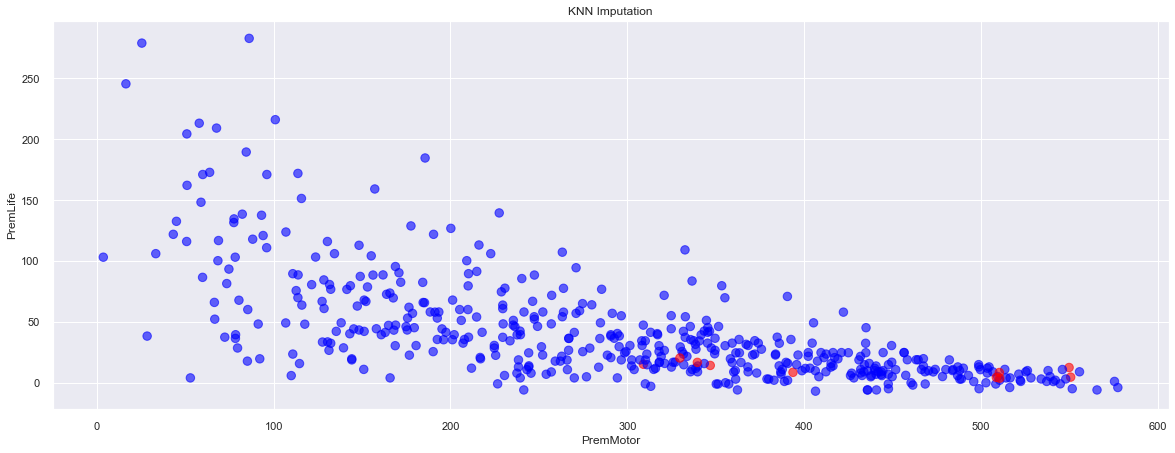

In [120]:
df_kmeans=df.copy()

le=LabelEncoder()

imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_kmeans[metric_features] = imputer.fit_transform(df_kmeans[metric_features])

dict_educdeg = {b'3 - BSc/MSc' : 3,  b'2 - High School' : 2, b'1 - Basic': 1 , b'4 - PhD': 4}
df_kmeans.replace({"EducDeg": dict_educdeg}, inplace=True)

# df_kmeans['EducDeg']=df_kmeans['EducDeg'].astype(int)

df_kmeans[non_metric_features] = imputer.fit_transform(df_kmeans[non_metric_features])

#round new values to one of the labels
df_kmeans['EducDeg']=df_kmeans['EducDeg'].round(0)
df_kmeans['Children']=df_kmeans['Children'].round(0)
df_kmeans['GeoLivArea']=df_kmeans['GeoLivArea'].round(0)


dict_educdeg = {3 : b'3 - BSc/MSc', 2: b'2 - High School',1 :  b'1 - Basic' , 4 : b'4 - PhD'}
df_kmeans.replace({"EducDeg": dict_educdeg}, inplace=True)


# Scatter plot

fig = plt.Figure()
null_values = df['PremLife'].isnull()
fig = df_kmeans[4020:4502].plot(x='PremMotor', y='PremLife', kind='scatter', c=null_values[4020:4502], cmap='bwr', title='KNN Imputation', colorbar=False, alpha=0.6, figsize=(20,7), s=72)


>> ### - Using linear interpolation for both metric and non metric:

In [121]:
# df_interpolation=df.copy()
# # Imputing with linear interpolation
# linear_interpolation = df_interpolation.interpolate(method='linear')

# # Plot imputed data

# linear_interpolation['PremLife'][4020:4502].plot(color='red', marker='o', linestyle='dotted')
# df_interpolation['PremLife'][4020:4502].plot(title='PremLife', marker='o', figsize=(35,7))

#### Keep with KNN

In [122]:
df_filled=df_kmeans.copy()

In [123]:
#convert some variables to int
df_filled = df_filled.astype({'FirstPolYear': int, 'BirthYear': int, 'MonthSal': int , 'GeoLivArea': int, 'Children': int})
#convert index to int
df_filled.index = df_filled.index.astype(int)

In [124]:
df_filled.sample(5)

FirstPolYear  BirthYear             EducDeg  MonthSal  GeoLivArea  \
CustID                                                                      
9585            1978       1939      b'3 - BSc/MSc'      4173           1   
3507            1986       1952  b'2 - High School'      3900           4   
4897            1994       1980        b'1 - Basic'      1410           4   
9145            1995       1974      b'3 - BSc/MSc'      1609           3   
4049            1980       1968  b'2 - High School'      2688           4   

        Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  \
CustID                                                               
9585           0      283.17        0.53     127.58          93.35   
3507           0     -119.35        1.10     163.03         481.75   
4897           1      592.80        0.30     203.15         371.75   
9145           1      428.53        0.33     436.75         104.45   
4049           1      383.97        0.40     456.42          84.45   

        PremHealth  PremLife  PremWork  
CustID                                  
9585        332.73      6.89     94.13  
3507        224.82     94.35     18.56  
4897        136.58    107.91     65.01  
9145        106.02     24.56      7.78  
4049         96.24     24.67     22.78

In [125]:
#Check if Nans were all filled
df_filled.isna().sum()

FirstPolYear     0
BirthYear        0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

In [126]:
# print columns with Nans
nans_index = df.isna().any(axis=1)
df[nans_index]

FirstPolYear  BirthYear             EducDeg  MonthSal  GeoLivArea  \
CustID                                                                       
22.0           1977.0     1958.0  b'2 - High School'       NaN         3.0   
69.0           1983.0     1977.0  b'2 - High School'    1399.0         4.0   
139.0          1979.0     1976.0  b'2 - High School'    2538.0         2.0   
144.0          1996.0     1990.0      b'3 - BSc/MSc'       NaN         4.0   
185.0          1993.0     1984.0  b'2 - High School'    2419.0         4.0   
...               ...        ...                 ...       ...         ...   
10011.0           NaN     1947.0  b'2 - High School'    3959.0         2.0   
10058.0        1983.0     1980.0  b'2 - High School'    1569.0         4.0   
10143.0        1986.0     1985.0      b'3 - BSc/MSc'    1652.0         3.0   
10285.0        1980.0     1987.0      b'3 - BSc/MSc'    1504.0         4.0   
10286.0        1985.0     1948.0      b'3 - BSc/MSc'    3878.0         4.0   

         Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  \
CustID                                                                
22.0          1.0      111.37        0.80     407.52         111.70   
69.0          1.0      476.65        0.33     330.73         186.70   
139.0         1.0      149.59        0.69     194.26         305.60   
144.0         1.0      -42.45        1.02     146.36         353.95   
185.0         1.0      -62.23        1.07        NaN         253.95   
...           ...         ...         ...        ...            ...   
10011.0       NaN     -128.24        1.14     177.81         153.35   
10058.0       1.0      222.60        0.55     235.60         211.15   
10143.0       1.0       55.67        0.88     257.05          94.45   
10285.0       1.0       -1.55        0.96     390.63          29.45   
10286.0       1.0      -57.45        1.04     269.05         217.25   

         PremHealth  PremLife  PremWork  
CustID                                   
22.0         100.13     24.67     30.34  
69.0         211.15       NaN     15.78  
139.0           NaN     37.34     17.67  
144.0        220.04    121.80     42.01  
185.0        230.60      5.89     43.12  
...             ...       ...       ...  
10011.0      311.28     67.79     35.45  
10058.0         NaN     32.34     68.79  
10143.0      308.39       NaN     13.78  
10285.0      179.70     -6.00       NaN  
10286.0      219.93     32.45       NaN  

[309 rows x 13 columns]

In [127]:
#print the same columns with Nans filled
df_filled[nans_index]

FirstPolYear  BirthYear             EducDeg  MonthSal  GeoLivArea  \
CustID                                                                      
22              1977       1958  b'2 - High School'      2541           3   
69              1983       1977  b'2 - High School'      1399           4   
139             1979       1976  b'2 - High School'      2538           2   
144             1996       1990      b'3 - BSc/MSc'      1721           4   
185             1993       1984  b'2 - High School'      2419           4   
...              ...        ...                 ...       ...         ...   
10011           1990       1947  b'2 - High School'      3959           2   
10058           1983       1980  b'2 - High School'      1569           4   
10143           1986       1985      b'3 - BSc/MSc'      1652           3   
10285           1980       1987      b'3 - BSc/MSc'      1504           4   
10286           1985       1948      b'3 - BSc/MSc'      3878           4   

        Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  \
CustID                                                               
22             1      111.37        0.80    407.520         111.70   
69             1      476.65        0.33    330.730         186.70   
139            1      149.59        0.69    194.260         305.60   
144            1      -42.45        1.02    146.360         353.95   
185            1      -62.23        1.07    264.428         253.95   
...          ...         ...         ...        ...            ...   
10011          1     -128.24        1.14    177.810         153.35   
10058          1      222.60        0.55    235.600         211.15   
10143          1       55.67        0.88    257.050          94.45   
10285          1       -1.55        0.96    390.630          29.45   
10286          1      -57.45        1.04    269.050         217.25   

        PremHealth  PremLife  PremWork  
CustID                                  
22         100.130    24.670    30.340  
69         211.150    33.784    15.780  
139        226.598    37.340    17.670  
144        220.040   121.800    42.010  
185        230.600     5.890    43.120  
...            ...       ...       ...  
10011      311.280    67.790    35.450  
10058      247.602    32.340    68.790  
10143      308.390    23.338    13.780  
10285      179.700    -6.000    15.736  
10286      219.930    32.450    41.830  

[309 rows x 13 columns]

In [128]:
#copy to df
df=df_filled.copy()

> ### 2.2 Coherence Check 

In [129]:
df[df['BirthYear']-df['FirstPolYear']>0]

FirstPolYear  BirthYear             EducDeg  MonthSal  GeoLivArea  \
CustID                                                                      
2               1981       1995  b'2 - High School'       677           4   
14              1983       2000        b'1 - Basic'      1043           3   
19              1981       1982        b'1 - Basic'      1414           3   
23              1976       1986  b'2 - High School'      1495           1   
41              1994       1995  b'2 - High School'      1177           4   
...              ...        ...                 ...       ...         ...   
10269           1987       1988      b'3 - BSc/MSc'      1414           3   
10274           1989       1992  b'2 - High School'      1035           1   
10285           1980       1987      b'3 - BSc/MSc'      1504           4   
10289           1982       1993  b'2 - High School'      1465           1   
10291           1994       1999        b'1 - Basic'       626           3   

        Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  \
CustID                                                               
2              1     -131.13        1.12      77.46         416.20   
14             1      -75.12        1.06      44.34         342.85   
19             1      230.38        0.71     313.17         373.40   
23             1      -89.79        1.08     209.04         308.95   
41             1      121.36        0.84      52.01         455.65   
...          ...         ...         ...        ...            ...   
10269          1       50.46        0.90     129.58         167.80   
10274          1      293.51        0.58     235.71         195.60   
10285          1       -1.55        0.96     390.63          29.45   
10289          1      795.15        0.35      67.79         820.15   
10291          1      176.26        0.85       6.89         878.50   

        PremHealth  PremLife  PremWork  
CustID                                  
2           116.69    194.48   106.130  
14          127.69    267.94    94.460  
19          121.80     14.78    72.570  
23          192.48     64.79    54.900  
41          135.47    146.36   148.030  
...            ...       ...       ...  
10269       184.48    165.92    75.460  
10274       103.13    170.92    58.120  
10285       179.70     -6.00    15.736  
10289       102.13    182.48    86.460  
10291       103.13    113.02   201.260  

[2003 rows x 13 columns]

FirstPolYear is very incoherent, having 2003 rows where BirthYear is higher than FirstPolYear

In [130]:
df.drop(columns='FirstPolYear', inplace=True)
metric_features.remove('FirstPolYear')

In [131]:
# print of unique values to check coherence
for col in df[non_metric_features]:
    print('\033[1;3mUnique values of "' + col + '"\033[0m ')
    print(df[col].unique())
    print('\n')

Unique values of "EducDeg" 
[b'2 - High School' b'1 - Basic' b'3 - BSc/MSc' b'4 - PhD']


Unique values of "Children" 
[1 0]


Unique values of "GeoLivArea" 
[1 4 3 2]




<AxesSubplot: xlabel='GeoLivArea', ylabel='count'>

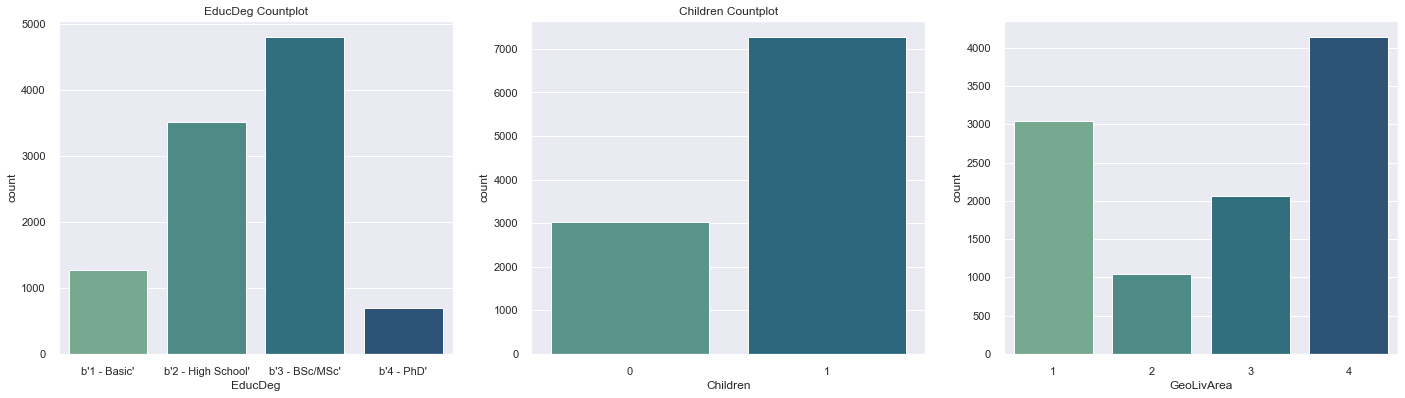

In [132]:
fig, ax = plt.subplots(1,3, figsize=(24,6))
ax[0].title.set_text('EducDeg Countplot')
ax[1].title.set_text('Children Countplot')
sns.countplot(data=df, x="EducDeg", ax=ax[0], palette='crest', order=df.EducDeg.value_counts().index.sort_values(), dodge=False)
sns.countplot(data=df, x="Children", ax=ax[1], palette='crest',  dodge=False)
sns.countplot(data=df, x="GeoLivArea", ax=ax[2], palette='crest',  dodge=False)


> ### 2.3 Feature Engineering 

>> #### Convert BirthYear to Age

In [133]:
#convert birth year to age
df['Age'] = 2016-df['BirthYear']
df.drop(columns='BirthYear', inplace=True)

#remove from metric_features list
metric_features.remove('BirthYear')

#add age to metric_features list
metric_features.append('Age')

In [134]:
df.describe(include='all').T

count unique             top  freq        mean          std  \
EducDeg          10293      4  b'3 - BSc/MSc'  4808         NaN          NaN   
MonthSal       10293.0    NaN             NaN   NaN  2506.40921  1156.183192   
GeoLivArea     10293.0    NaN             NaN   NaN    2.709414     1.266241   
Children       10293.0    NaN             NaN   NaN    0.706597     0.455344   
CustMonVal     10293.0    NaN             NaN   NaN  177.929963  1946.091554   
ClaimsRate     10293.0    NaN             NaN   NaN    0.742728     2.917385   
PremMotor      10293.0    NaN             NaN   NaN  300.702459    211.67798   
PremHousehold  10293.0    NaN             NaN   NaN  210.419863   352.635041   
PremHealth     10293.0    NaN             NaN   NaN  171.596339   295.845039   
PremLife       10293.0    NaN             NaN   NaN   41.616451    47.353344   
PremWork       10293.0    NaN             NaN   NaN   41.155432    51.381233   
Age            10293.0    NaN             NaN   NaN   47.994365     19.70243   

                     min     25%     50%     75%       max  
EducDeg              NaN     NaN     NaN     NaN       NaN  
MonthSal           333.0  1706.0  2501.0  3290.0   55215.0  
GeoLivArea           1.0     1.0     3.0     4.0       4.0  
Children             0.0     0.0     1.0     1.0       1.0  
CustMonVal    -165680.42   -9.44  187.03  399.86  11875.89  
ClaimsRate           0.0    0.39    0.72    0.98     256.2  
PremMotor          -4.11  191.26  299.28   408.3  11604.42  
PremHousehold      -75.0   49.45   132.8  290.05   25048.8  
PremHealth         -2.11  111.91  162.92  219.04   28272.0  
PremLife            -7.0    9.89   25.45   57.01     398.3  
PremWork           -12.0   10.67   25.67   56.12    1988.7  
Age                 15.0    33.0    48.0    63.0     988.0

In [135]:
df.describe().round(2).T

count     mean      std        min      25%      50%  \
MonthSal       10293.0  2506.41  1156.18     333.00  1706.00  2501.00   
GeoLivArea     10293.0     2.71     1.27       1.00     1.00     3.00   
Children       10293.0     0.71     0.46       0.00     0.00     1.00   
CustMonVal     10293.0   177.93  1946.09 -165680.42    -9.44   187.03   
ClaimsRate     10293.0     0.74     2.92       0.00     0.39     0.72   
PremMotor      10293.0   300.70   211.68      -4.11   191.26   299.28   
PremHousehold  10293.0   210.42   352.64     -75.00    49.45   132.80   
PremHealth     10293.0   171.60   295.85      -2.11   111.91   162.92   
PremLife       10293.0    41.62    47.35      -7.00     9.89    25.45   
PremWork       10293.0    41.16    51.38     -12.00    10.67    25.67   
Age            10293.0    47.99    19.70      15.00    33.00    48.00   

                   75%       max  
MonthSal       3290.00  55215.00  
GeoLivArea        4.00      4.00  
Children          1.00      1.00  
CustMonVal      399.86  11875.89  
ClaimsRate        0.98    256.20  
PremMotor       408.30  11604.42  
PremHousehold   290.05  25048.80  
PremHealth      219.04  28272.00  
PremLife         57.01    398.30  
PremWork         56.12   1988.70  
Age              63.00    988.00

> ### 2.4 Outliers

>> #### Analysis before outliers

In [136]:
def box_plot_all_vars(data):
    # All Numeric Variables' Box Plots in one figure
    sns.set()

    # Prepare figure. Create individual axes where each box plot will be placed
    fig, axes = plt.subplots(4, ceil(len(metric_features) / 4), figsize=(25, 20))

    # Plot data
    # Iterate across axes objects and associate each box plot (hint: use the ax argument):
    for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
        bxplot = sns.boxplot(x=data[feat], ax=ax, color='chartreuse', fliersize=8)
        bxplot.set_xlabel(fontsize=16, xlabel=feat)

    
        
    # Layout
    # Add a centered title to the figure:
    title = "Numeric Variables' Box Plots"

    plt.suptitle(title, size=30)

    plt.show()

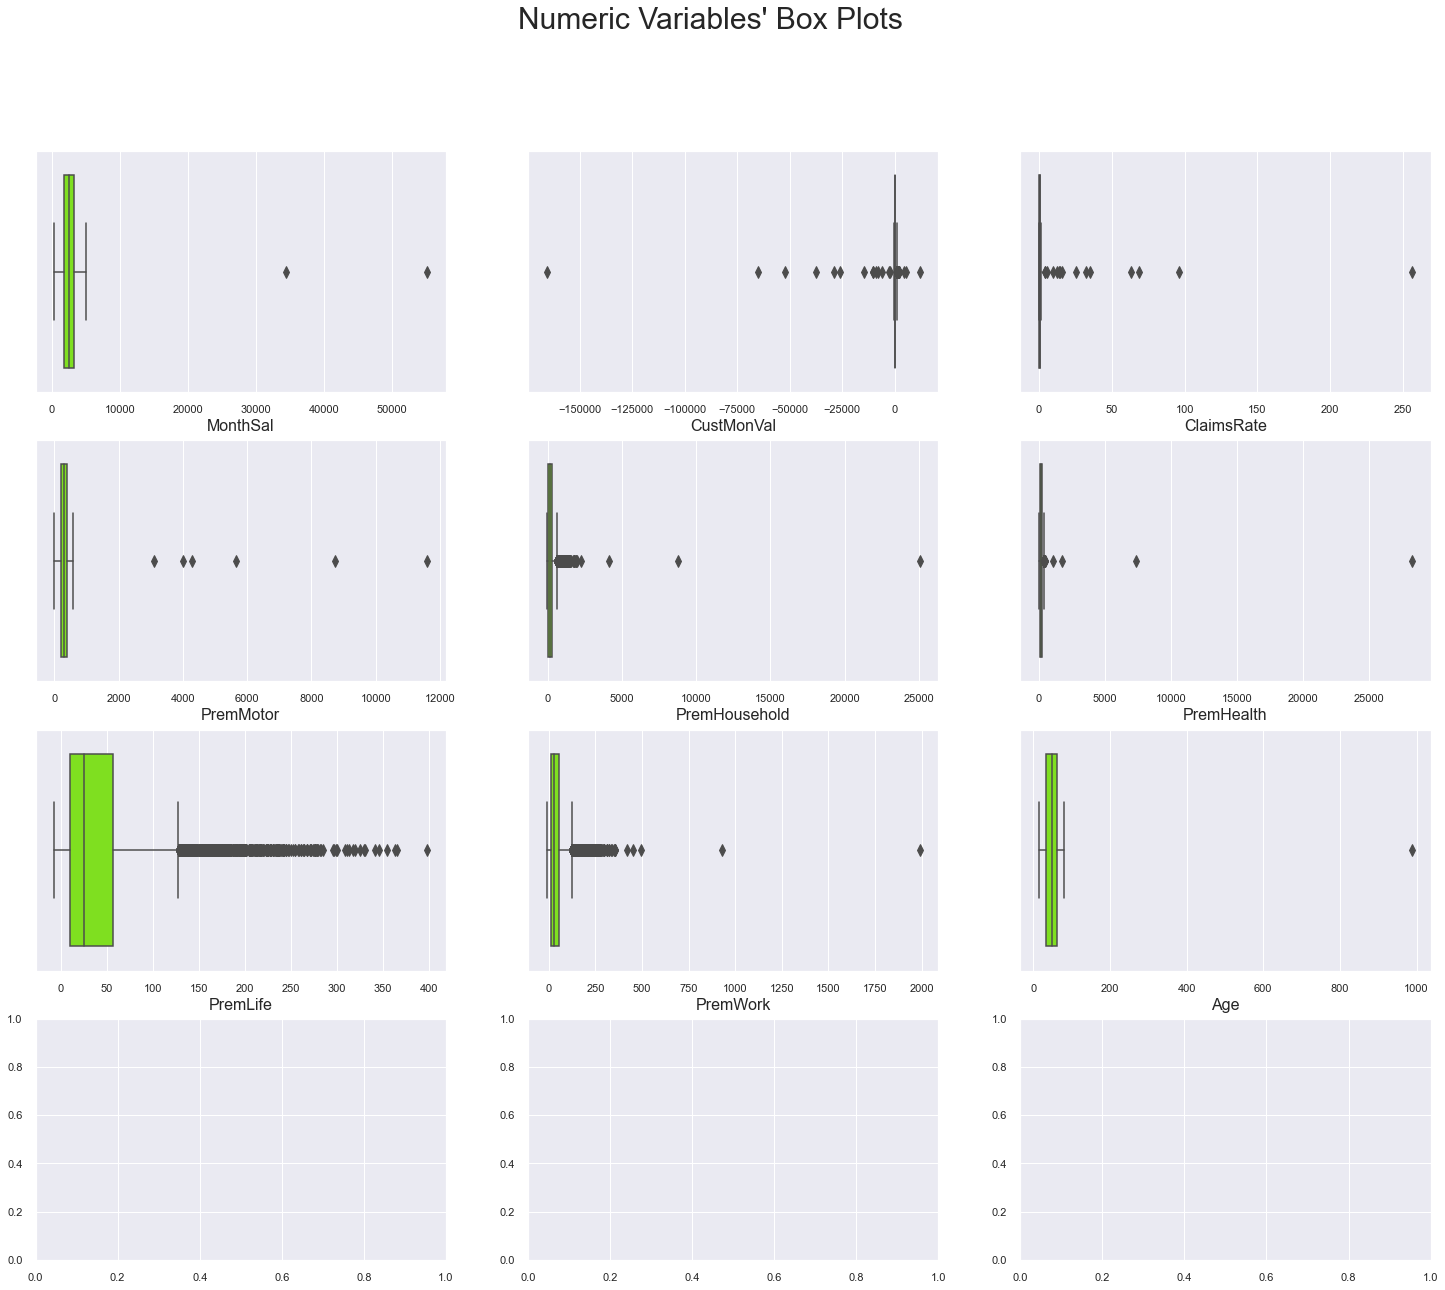

In [137]:
box_plot_all_vars(df)

>> ### Observation method:


In [138]:
##Following quartiles
filters1 = (
    (df['MonthSal']<=5500)
    &
    (df['CustMonVal']>=-3000)
    &
    (df['CustMonVal']<=3000)
    &
    (df['ClaimsRate']<=6)
    &
    (df['PremMotor']<=700)
    &
    (df['PremHousehold']<=1500)
    &
    (df['PremHealth']<=760)
    &
    (df['PremLife']<=150)
    &
    (df['Age']<=85)
)

df_1 = df[filters1]
print('Percentage of data kept after removing outliers:', np.round(df_1.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.9554


>> ### IQR method:


In [139]:
##IQR method
q25 = df.quantile(.25)
q75 = df.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters2 = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters2.append(df[metric].between(llim, ulim, inclusive='both'))

filters2 = pd.Series(np.all(filters2, 0))
df_2=df.copy()
df_2['filters2'] = filters2.to_list()
df_2=df_2[df_2['filters2']!=False]
print('Percentage of data kept after removing outliers:', np.round(df_2.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.8542


>> ### Combining Both:

In [140]:
##Combining the 2 above
df_3 = df.copy()
df_3['filters1'] = filters1.to_list()
df_3['filters2'] = filters2
df_3 = df_3[(df_3['filters1']==True) | (df_3['filters2']==True)]
print('Percentage of data kept after removing outliers:', np.round(df_3.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.9947


>> ### Observation method more conservative:

In [141]:
##Removing more critical data points
filters3 = (
    (df['MonthSal']<=30000)
    &
    (df['CustMonVal']>=-75000)
    &
    (df['ClaimsRate']<=100)
    &
    (df['PremMotor']<=6000)
    &
    (df['PremHousehold']<=5000)
    &
    (df['PremHealth']<=5000)
    &
    (df['PremLife']<=398)
    &
    (df['Age']<=85)
)

df_4 = df[filters3]
print('Percentage of data kept after removing outliers:', np.round(df_4.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.9989


In [142]:
## print para comparar os dois metodos de outliers, e colocar que se escolheu so usar o manual
df_3.drop(columns=['filters1','filters2'], inplace=True)
print('Data shape before outliers removal:')
print(df.shape)
print('Data shape after outliers removal:')
print('df_1: ', df_1.shape)
print('df_2: ', df_2.shape)
print('df_3: ', df_3.shape)
print('df_4: ', df_4.shape)

Data shape before outliers removal:
(10293, 12)
Data shape after outliers removal:
df_1:  (9834, 12)
df_2:  (8792, 13)
df_3:  (10238, 12)
df_4:  (10282, 12)


#### Keep with combination of observation and IQR method

In [143]:
df=df_1.copy()
# df=df_3.copy()

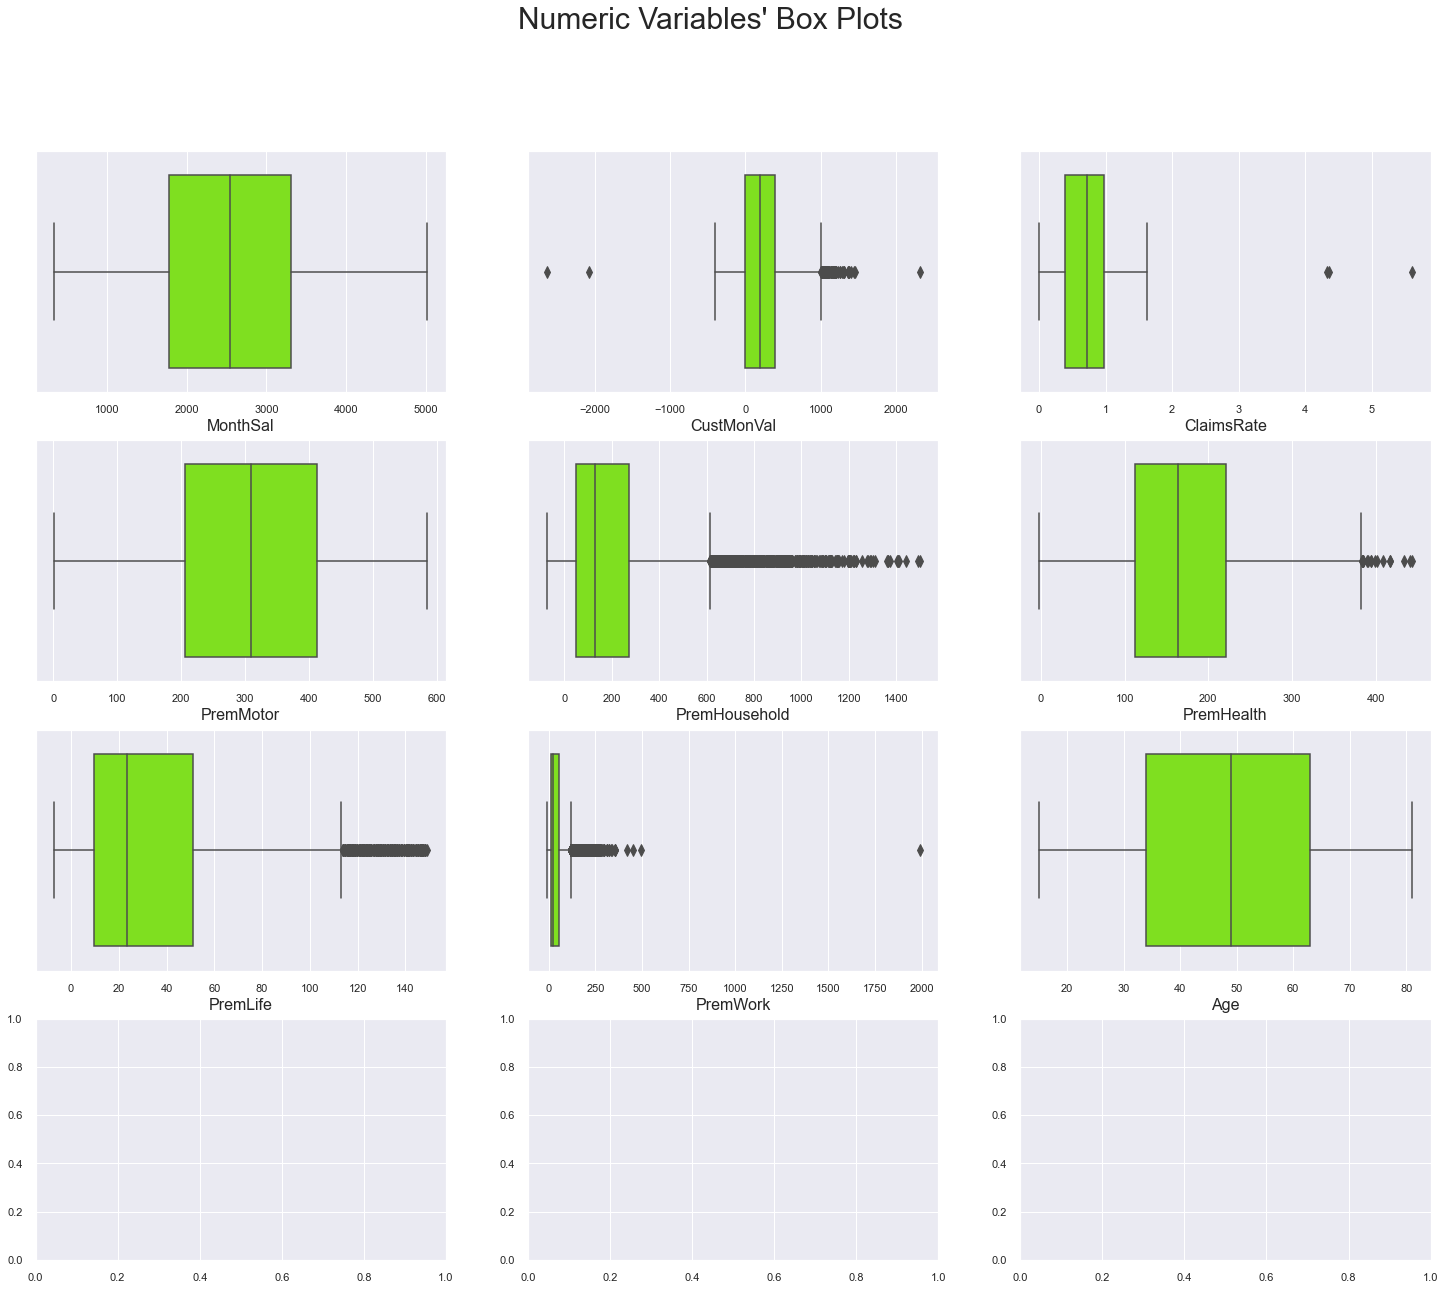

In [144]:
box_plot_all_vars(df)

> ### 2.5 Feature Selection using correlations

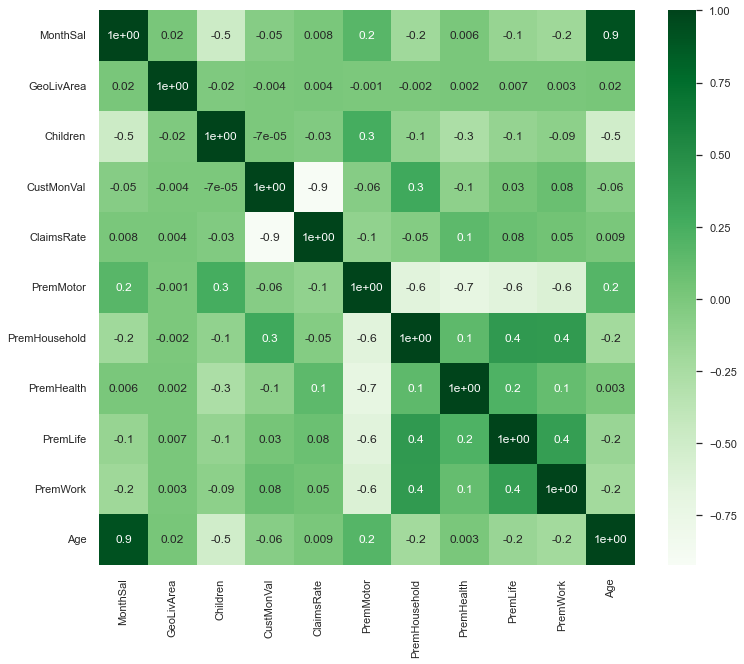

In [145]:
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Greens, fmt='.1')
    plt.show()
cor_pearson = df.corr()
cor_heatmap(cor_pearson)


In [146]:
##Drop columns with very high correlations
df.drop(columns=['MonthSal','CustMonVal'], inplace=True)
# df.drop(columns=['CustMonVal'], inplace=True)
metric_features.remove('MonthSal')
metric_features.remove('CustMonVal')

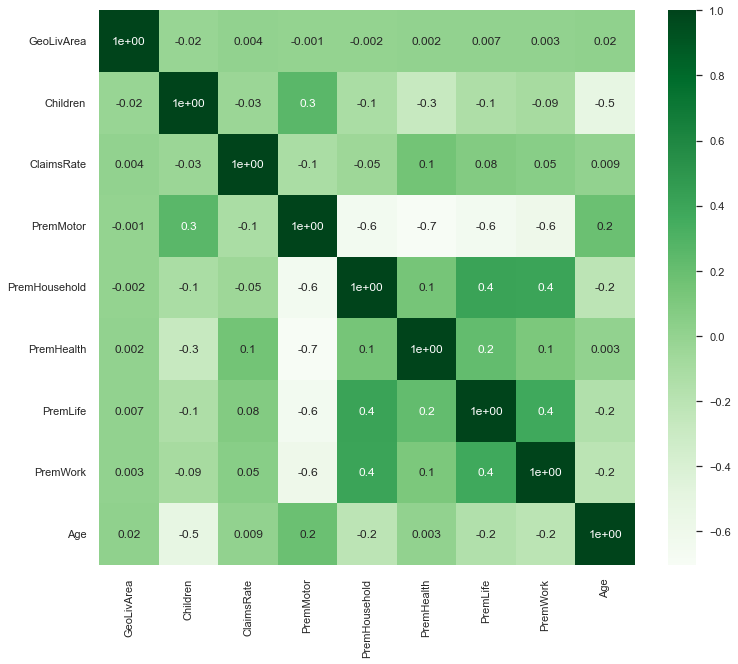

In [147]:
cor_pearson = df.corr()
cor_heatmap(cor_pearson)

In [148]:
df[metric_features].sample(5)

ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  PremWork  \
CustID                                                                         
7697          0.44      23.56         799.60       82.46    147.25    161.81   
574           0.49     210.93         137.25      114.02    127.58    117.02   
6366          0.46     373.07          93.90      128.58     44.23     48.23   
8159          0.32     364.18         157.80      172.70     22.67     12.89   
6259          0.15     558.55         -50.00       30.45      7.00     -2.00   

        Age  
CustID       
7697     19  
574      28  
6366     60  
8159     38  
6259     45

In [149]:
df_not_scaled = df.copy()

> ### 2.6 Scaling

>> ### MinMaxScaler:

In [150]:
df_minmax=df.copy()
#normalize with minmaxscaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_minmax[metric_features])
df_minmax[metric_features] = scaled_features

df_minmax.describe().T

count      mean       std  min       25%       50%       75%  \
GeoLivArea     9834.0  2.706020  1.266048  1.0  1.000000  3.000000  4.000000   
Children       9834.0  0.709681  0.453933  0.0  0.000000  1.000000  1.000000   
ClaimsRate     9834.0  0.121269  0.058205  0.0  0.069643  0.128571  0.175000   
PremMotor      9834.0  0.522646  0.227475  0.0  0.350332  0.528383  0.703620   
PremHousehold  9834.0  0.171557  0.140283  0.0  0.078415  0.128922  0.222180   
PremHealth     9834.0  0.385108  0.167500  0.0  0.258489  0.373126  0.501000   
PremLife       9834.0  0.268262  0.218455  0.0  0.107468  0.196426  0.372230   
PremWork       9834.0  0.025640  0.024650  0.0  0.010941  0.018301  0.032549   
Age            9834.0  0.510680  0.256339  0.0  0.287879  0.515152  0.727273   

               max  
GeoLivArea     4.0  
Children       1.0  
ClaimsRate     1.0  
PremMotor      1.0  
PremHousehold  1.0  
PremHealth     1.0  
PremLife       1.0  
PremWork       1.0  
Age            1.0

>> ### StandartScaler:

In [151]:
df_st_scaler=df.copy()
#normalize with standart scaler

standart_scaler = StandardScaler()
standart_scaler_features = standart_scaler.fit_transform(df_st_scaler[metric_features])
df_st_scaler[metric_features] = standart_scaler_features

df_st_scaler.describe().T

count          mean       std       min       25%       50%  \
GeoLivArea     9834.0  2.706020e+00  1.266048  1.000000  1.000000  3.000000   
Children       9834.0  7.096807e-01  0.453933  0.000000  0.000000  1.000000   
ClaimsRate     9834.0  3.108715e-16  1.000051 -2.083597 -0.887023  0.125462   
PremMotor      9834.0 -4.804870e-17  1.000051 -2.297714 -0.757548  0.025221   
PremHousehold  9834.0 -7.225368e-17  1.000051 -1.223000 -0.663997 -0.303942   
PremHealth     9834.0  3.338120e-16  1.000051 -2.299269 -0.755972 -0.071538   
PremLife       9834.0  2.182061e-16  1.000051 -1.228058 -0.736089 -0.328850   
PremWork       9834.0  1.275278e-16  1.000051 -1.040224 -0.596342 -0.297750   
Age            9834.0  1.625708e-16  1.000051 -1.992304 -0.869210  0.017443   

                    75%        max  
GeoLivArea     4.000000   4.000000  
Children       1.000000   1.000000  
ClaimsRate     0.923177  15.097968  
PremMotor      0.795615   2.098592  
PremHousehold  0.360880   5.905821  
PremHealth     0.691926   3.671179  
PremLife       0.475951   3.349781  
PremWork       0.280270  39.529693  
Age            0.844987   1.908971

In [152]:
df_st_scaler

EducDeg  GeoLivArea  Children  ClaimsRate  PremMotor  \
CustID                                                                    
1       b'2 - High School'           1         1   -0.887023   0.520959   
3             b'1 - Basic'           3         0   -1.224518  -0.757756   
4           b'3 - BSc/MSc'           4         1    0.953859  -0.936113   
5           b'3 - BSc/MSc'           4         1    0.677726   0.240425   
6       b'2 - High School'           4         1    0.984540   1.009990   
...                    ...         ...       ...         ...        ...   
10292           b'4 - PhD'           2         0    0.861814   0.655762   
10293         b'1 - Basic'           3         0   -2.083597  -1.304581   
10294       b'3 - BSc/MSc'           1         1   -1.439288   0.730285   
10295         b'1 - Basic'           2         1   -0.089308  -0.890073   
10296           b'4 - PhD'           1         1   -1.255200   0.809027   

        PremHousehold  PremHealth  PremLife  PremWork       Age  
CustID                                                           
1           -0.523057   -0.307152  0.355451 -0.454397 -0.869210  
3            0.134288   -0.599388  1.508853  1.211024 -0.159887  
4           -0.686656    1.904210  0.013300 -0.222215 -0.810100  
5           -0.666489    0.178969 -0.472219  0.043627 -0.337218  
6           -0.797460   -0.730613 -0.817595 -0.641359  0.667656  
...               ...         ...       ...       ...       ...  
10292       -0.659012    0.061162 -0.736089 -0.497183  1.081427  
10293        3.810748   -0.348881 -0.644907  1.334922  0.904097  
10294       -0.281283   -0.362298 -0.651357 -0.697731 -0.514549  
10295        0.073788    0.390700  0.850646  1.492683 -0.573659  
10296       -0.455079   -0.375716 -0.820820 -0.535508 -0.810100  

[9834 rows x 10 columns]

>> ### Robust Scaler:

In [153]:
df_robust_scaler=df.copy()
#normalize with robust scaler

robust_scaler = RobustScaler()
robust_scaler_features = robust_scaler.fit_transform(df_robust_scaler[metric_features])
df_robust_scaler[metric_features] = robust_scaler_features

df_robust_scaler.describe().T

count      mean       std       min       25%           50%  \
GeoLivArea     9834.0  2.706020  1.266048  1.000000  1.000000  3.000000e+00   
Children       9834.0  0.709681  0.453933  0.000000  0.000000  1.000000e+00   
ClaimsRate     9834.0 -0.069308  0.552453 -1.220339 -0.559322  0.000000e+00   
PremMotor      9834.0 -0.016239  0.643880 -1.495615 -0.503984  0.000000e+00   
PremHousehold  9834.0  0.296564  0.975776 -0.896750 -0.351315  0.000000e+00   
PremHealth     9834.0  0.049408  0.690692 -1.538597 -0.472709  0.000000e+00   
PremLife       9834.0  0.271320  0.825097 -0.741896 -0.335994  0.000000e+00   
PremWork       9834.0  0.339660  1.140814 -0.846981 -0.340620 -4.119968e-17   
Age            9834.0 -0.010176  0.583393 -1.172414 -0.517241  0.000000e+00   

                    75%        max  
GeoLivArea     4.000000   4.000000  
Children       1.000000   1.000000  
ClaimsRate     0.440678   8.271186  
PremMotor      0.496016   1.334934  
PremHousehold  0.648685   6.059032  
PremHealth     0.527291   2.584932  
PremLife       0.664006   3.035075  
PremWork       0.659380  45.433380  
Age            0.482759   1.103448

### Keep with standard scaler method

In [154]:
df=df_st_scaler.copy()
df_cat_num = df_st_scaler.copy()
# df=df_robust_scaler.copy()
# df_cat_num = df_robust_scaler.copy()

In [155]:
df.isna().sum()

EducDeg          0
GeoLivArea       0
Children         0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
Age              0
dtype: int64

In [156]:
df[non_metric_features]

EducDeg  Children  GeoLivArea
CustID                                          
1       b'2 - High School'         1           1
3             b'1 - Basic'         0           3
4           b'3 - BSc/MSc'         1           4
5           b'3 - BSc/MSc'         1           4
6       b'2 - High School'         1           4
...                    ...       ...         ...
10292           b'4 - PhD'         0           2
10293         b'1 - Basic'         0           3
10294       b'3 - BSc/MSc'         1           1
10295         b'1 - Basic'         1           2
10296           b'4 - PhD'         1           1

[9834 rows x 3 columns]

> ### 2.7 One Hot Encoder
>>#### Using standart scaled DF:

In [157]:
##ONE HOT ENCODING
df_ohc = df[non_metric_features].copy()

ohc = OneHotEncoder(sparse=False)
ohc_feat = ohc.fit_transform(df_ohc)
ohc_feat_names = ohc.get_feature_names_out()
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)
ohc_df.drop(['Children_0'],axis=1, inplace=True)
ohc_df

EducDeg_b'1 - Basic'  EducDeg_b'2 - High School'  \
CustID                                                     
1                        0.0                         1.0   
3                        1.0                         0.0   
4                        0.0                         0.0   
5                        0.0                         0.0   
6                        0.0                         1.0   
...                      ...                         ...   
10292                    0.0                         0.0   
10293                    1.0                         0.0   
10294                    0.0                         0.0   
10295                    1.0                         0.0   
10296                    0.0                         0.0   

        EducDeg_b'3 - BSc/MSc'  EducDeg_b'4 - PhD'  Children_1  GeoLivArea_1  \
CustID                                                                         
1                          0.0                 0.0         1.0           1.0   
3                          0.0                 0.0         0.0           0.0   
4                          1.0                 0.0         1.0           0.0   
5                          1.0                 0.0         1.0           0.0   
6                          0.0                 0.0         1.0           0.0   
...                        ...                 ...         ...           ...   
10292                      0.0                 1.0         0.0           0.0   
10293                      0.0                 0.0         0.0           0.0   
10294                      1.0                 0.0         1.0           1.0   
10295                      0.0                 0.0         1.0           0.0   
10296                      0.0                 1.0         1.0           1.0   

        GeoLivArea_2  GeoLivArea_3  GeoLivArea_4  
CustID                                            
1                0.0           0.0           0.0  
3                0.0           1.0           0.0  
4                0.0           0.0           1.0  
5                0.0           0.0           1.0  
6                0.0           0.0           1.0  
...              ...           ...           ...  
10292            1.0           0.0           0.0  
10293            0.0           1.0           0.0  
10294            0.0           0.0           0.0  
10295            1.0           0.0           0.0  
10296            0.0           0.0           0.0  

[9834 rows x 9 columns]

In [158]:
df_scaled=df.merge(ohc_df, on = 'CustID')
df_scaled.drop(['Children', 'EducDeg', 'GeoLivArea'],axis=1, inplace=True)
df_scaled

ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  PremWork  \
CustID                                                                         
1        -0.887023   0.520959      -0.523057   -0.307152  0.355451 -0.454397   
3        -1.224518  -0.757756       0.134288   -0.599388  1.508853  1.211024   
4         0.953859  -0.936113      -0.686656    1.904210  0.013300 -0.222215   
5         0.677726   0.240425      -0.666489    0.178969 -0.472219  0.043627   
6         0.984540   1.009990      -0.797460   -0.730613 -0.817595 -0.641359   
...            ...        ...            ...         ...       ...       ...   
10292     0.861814   0.655762      -0.659012    0.061162 -0.736089 -0.497183   
10293    -2.083597  -1.304581       3.810748   -0.348881 -0.644907  1.334922   
10294    -1.439288   0.730285      -0.281283   -0.362298 -0.651357 -0.697731   
10295    -0.089308  -0.890073       0.073788    0.390700  0.850646  1.492683   
10296    -1.255200   0.809027      -0.455079   -0.375716 -0.820820 -0.535508   

             Age  EducDeg_b'1 - Basic'  EducDeg_b'2 - High School'  \
CustID                                                               
1      -0.869210                   0.0                         1.0   
3      -0.159887                   1.0                         0.0   
4      -0.810100                   0.0                         0.0   
5      -0.337218                   0.0                         0.0   
6       0.667656                   0.0                         1.0   
...          ...                   ...                         ...   
10292   1.081427                   0.0                         0.0   
10293   0.904097                   1.0                         0.0   
10294  -0.514549                   0.0                         0.0   
10295  -0.573659                   1.0                         0.0   
10296  -0.810100                   0.0                         0.0   

        EducDeg_b'3 - BSc/MSc'  EducDeg_b'4 - PhD'  Children_1  GeoLivArea_1  \
CustID                                                                         
1                          0.0                 0.0         1.0           1.0   
3                          0.0                 0.0         0.0           0.0   
4                          1.0                 0.0         1.0           0.0   
5                          1.0                 0.0         1.0           0.0   
6                          0.0                 0.0         1.0           0.0   
...                        ...                 ...         ...           ...   
10292                      0.0                 1.0         0.0           0.0   
10293                      0.0                 0.0         0.0           0.0   
10294                      1.0                 0.0         1.0           1.0   
10295                      0.0                 0.0         1.0           0.0   
10296                      0.0                 1.0         1.0           1.0   

        GeoLivArea_2  GeoLivArea_3  GeoLivArea_4  
CustID                                            
1                0.0           0.0           0.0  
3                0.0           1.0           0.0  
4                0.0           0.0           1.0  
5                0.0           0.0           1.0  
6                0.0           0.0           1.0  
...              ...           ...           ...  
10292            1.0           0.0           0.0  
10293            0.0           1.0           0.0  
10294            0.0           0.0           0.0  
10295            1.0           0.0           0.0  
10296            0.0           0.0           0.0  

[9834 rows x 16 columns]

>> #### Using MinMaxScaler:

In [159]:
# ##ONE HOT ENCODING
# df_ohc = df_minmax[non_metric_features].copy()

# ohc = OneHotEncoder(sparse=False)
# ohc_feat = ohc.fit_transform(df_ohc)
# ohc_feat_names = ohc.get_feature_names_out()
# ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)
# ohc_df.drop(['Children_0'],axis=1, inplace=True)
# ohc_df

In [160]:
# df_minmax=df_minmax.merge(ohc_df, on = 'CustID')
# df_minmax.drop(['Children', 'EducDeg', 'GeoLivArea'],axis=1, inplace=True)
# df_minmax

#### Keep one hot from standart scaler

In [161]:
df=df_scaled.copy()
df

ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  PremWork  \
CustID                                                                         
1        -0.887023   0.520959      -0.523057   -0.307152  0.355451 -0.454397   
3        -1.224518  -0.757756       0.134288   -0.599388  1.508853  1.211024   
4         0.953859  -0.936113      -0.686656    1.904210  0.013300 -0.222215   
5         0.677726   0.240425      -0.666489    0.178969 -0.472219  0.043627   
6         0.984540   1.009990      -0.797460   -0.730613 -0.817595 -0.641359   
...            ...        ...            ...         ...       ...       ...   
10292     0.861814   0.655762      -0.659012    0.061162 -0.736089 -0.497183   
10293    -2.083597  -1.304581       3.810748   -0.348881 -0.644907  1.334922   
10294    -1.439288   0.730285      -0.281283   -0.362298 -0.651357 -0.697731   
10295    -0.089308  -0.890073       0.073788    0.390700  0.850646  1.492683   
10296    -1.255200   0.809027      -0.455079   -0.375716 -0.820820 -0.535508   

             Age  EducDeg_b'1 - Basic'  EducDeg_b'2 - High School'  \
CustID                                                               
1      -0.869210                   0.0                         1.0   
3      -0.159887                   1.0                         0.0   
4      -0.810100                   0.0                         0.0   
5      -0.337218                   0.0                         0.0   
6       0.667656                   0.0                         1.0   
...          ...                   ...                         ...   
10292   1.081427                   0.0                         0.0   
10293   0.904097                   1.0                         0.0   
10294  -0.514549                   0.0                         0.0   
10295  -0.573659                   1.0                         0.0   
10296  -0.810100                   0.0                         0.0   

        EducDeg_b'3 - BSc/MSc'  EducDeg_b'4 - PhD'  Children_1  GeoLivArea_1  \
CustID                                                                         
1                          0.0                 0.0         1.0           1.0   
3                          0.0                 0.0         0.0           0.0   
4                          1.0                 0.0         1.0           0.0   
5                          1.0                 0.0         1.0           0.0   
6                          0.0                 0.0         1.0           0.0   
...                        ...                 ...         ...           ...   
10292                      0.0                 1.0         0.0           0.0   
10293                      0.0                 0.0         0.0           0.0   
10294                      1.0                 0.0         1.0           1.0   
10295                      0.0                 0.0         1.0           0.0   
10296                      0.0                 1.0         1.0           1.0   

        GeoLivArea_2  GeoLivArea_3  GeoLivArea_4  
CustID                                            
1                0.0           0.0           0.0  
3                0.0           1.0           0.0  
4                0.0           0.0           1.0  
5                0.0           0.0           1.0  
6                0.0           0.0           1.0  
...              ...           ...           ...  
10292            1.0           0.0           0.0  
10293            0.0           1.0           0.0  
10294            0.0           0.0           0.0  
10295            1.0           0.0           0.0  
10296            0.0           0.0           0.0  

[9834 rows x 16 columns]

In [162]:
# ProfileReport(
#     df,
#     title='Data Preprocessed Analysis',
#     correlations={
#         "pearson": {"calculate": True},
#         "spearman": {"calculate": False},
#         "kendall": {"calculate": False},
#         "phi_k": {"calculate": False},
#         "cramers": {"calculate": False},
#     },
# )

## PCA
#### Using standart scaler df

In [163]:
# ##PCA
# df_pca = df.copy()


# pca = PCA()
# pca_feat = pca.fit_transform(df_pca[metric_features])

In [164]:
# pd.DataFrame(
#     {"Eigenvalue": pca.explained_variance_,
#      "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
#      "Proportion": pca.explained_variance_ratio_,
#      "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
#     index=range(1, pca.n_components_ + 1)
# )

##### We can notice that only a reduction to 5 components (~82%) would be representative of the data set. Since originally, we had 13 features, it doesn't make sense to keep 5 components.
#### Let's try with the df from min max scaler...


In [165]:
# ##PCA
# df_pca_min_max = df_minmax.copy()


# pca_min_max = PCA()
# pca_feat_min_max = pca_min_max.fit_transform(df_pca_min_max[metric_features])

In [166]:
# pd.DataFrame(
#     {"Eigenvalue": pca_min_max.explained_variance_,
#      "Difference": np.insert(np.diff(pca_min_max.explained_variance_), 0, 0),
#      "Proportion": pca_min_max.explained_variance_ratio_,
#      "Cumulative": np.cumsum(pca_min_max.explained_variance_ratio_)},
#     index=range(1, pca_min_max.n_components_ + 1)
# )

##### Now it's clear that with only 3 components, we have 90% of explained variance
##### Let's keep this DF to visualize PCA

In [167]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


# ax1.plot(pca_min_max.explained_variance_, marker=".", markersize=12)
# ax2.plot(pca_min_max.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
# ax2.plot(np.cumsum(pca_min_max.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")


# ax2.legend()
# ax1.set_title("Scree Plot", fontsize=14)
# ax2.set_title("Variance Explained", fontsize=14)
# ax1.set_ylabel("Eigenvalue")
# ax2.set_ylabel("Proportion")
# ax1.set_xlabel("Components")
# ax2.set_xlabel("Components")
# ax1.set_xticks(range(0, pca_min_max.n_components_, 2))
# ax1.set_xticklabels(range(1, pca_min_max.n_components_ + 1, 2))
# ax2.set_xticks(range(0, pca_min_max.n_components_, 2))
# ax2.set_xticklabels(range(1, pca_min_max.n_components_ + 1, 2))

# plt.show()

In [168]:
# pca_min_max = PCA(n_components=3)
# pca_feat_min_max = pca_min_max.fit_transform(df_pca_min_max[metric_features])
# pca_feat_names = [f"PC{i}" for i in range(pca_min_max.n_components_)]
# pca_df = pd.DataFrame(pca_feat_min_max, index=df_pca_min_max.index, columns=pca_feat_names) 
# pca_df

In [169]:
# df_pca_min_max = pd.concat([df_pca_min_max, pca_df], axis=1)
# df_pca_min_max.head()

In [170]:
# def _color_red_or_green(val):
#     if val < -0.45:
#         color = 'background-color: red'
#     elif val > 0.45:
#         color = 'background-color: green'
#     else:
#         color = ''
#     return color
    


# # Interpreting each Principal Component
# loadings = df_pca_min_max[metric_features + pca_feat_names].corr().loc[metric_features, pca_feat_names]
# loadings.style.applymap(_color_red_or_green)

In [171]:
# df_pca_min_max['HighScore'] = df_pca_min_max[['PC0', 'PC1', 'PC2']].idxmax(axis=1)
# df_pca_min_max

In [172]:
# df_pca_min_max.head()

In [173]:
# df = df_pca.copy()
# df.head()

### We just did PCA in order to test if it would be helpful or not. But since we doesn't have a lot of variables and the results from PCA weren't that good, we discarded the use of PCA.


> ### 2.8 Feature selection with SOMs and 
> ### Removing DBSCAN outliers

In [174]:
dbscan = DBSCAN(eps=1.9, min_samples=20, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df[metric_features])
Counter(dbscan_labels)

Counter({0: 9807, -1: 27})

In [175]:
# Save the newly detected outliers (they will be classified later based on the final clusters)
df_out = df[dbscan_labels==-1].copy()

# New df without outliers and 'rcn'
df = df[dbscan_labels!=-1]\
    .copy()

df_cat_num = df_cat_num[df_cat_num.index.isin(df.index)]
df_not_scaled = df_not_scaled[df_not_scaled.index.isin(df.index)]


In [176]:
df_not_scaled

EducDeg  GeoLivArea  Children  ClaimsRate  PremMotor  \
CustID                                                                    
1       b'2 - High School'           1         1        0.39     375.85   
3             b'1 - Basic'           3         0        0.28     206.15   
4           b'3 - BSc/MSc'           4         1        0.99     182.48   
5           b'3 - BSc/MSc'           4         1        0.90     338.62   
6       b'2 - High School'           4         1        1.00     440.75   
...                    ...         ...       ...         ...        ...   
10292           b'4 - PhD'           2         0        0.96     393.74   
10293         b'1 - Basic'           3         0        0.00     133.58   
10294       b'3 - BSc/MSc'           1         1        0.21     403.63   
10295         b'1 - Basic'           2         1        0.65     188.59   
10296           b'4 - PhD'           1         1        0.27     414.08   

        PremHousehold  PremHealth  PremLife  PremWork  Age  
CustID                                                      
1               79.45      146.36     47.01     16.89   34  
3              224.50      124.58     86.35     99.02   46  
4               43.35      311.17     35.34     28.34   35  
5               47.80      182.59     18.78     41.45   43  
6               18.90      114.80      7.00      7.67   60  
...               ...         ...       ...       ...  ...  
10292           49.45      173.81      9.78     14.78   67  
10293         1035.75      143.25     12.89    105.13   64  
10294          132.80      142.25     12.67      4.89   40  
10295          211.15      198.37     63.90    112.91   39  
10296           94.45      141.25      6.89     12.89   35  

[9807 rows x 10 columns]

In [177]:
metric_features

['ClaimsRate',
 'PremMotor',
 'PremHousehold',
 'PremHealth',
 'PremLife',
 'PremWork',
 'Age']

In [178]:
from sompy import sompy
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

sm = sompy.SOMFactory().build(
    df[metric_features].values, 
    mapsize=[10, 10],  # NEEDS TO BE A LIST
    initialization='random', 
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=metric_features
)
sm.train(n_job=4, verbose='info', train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.049000, quantization error: 2.229245

 epoch: 2 ---> elapsed time:  0.037000, quantization error: 2.379483

 epoch: 3 ---> elapsed time:  0.034000, quantization error: 2.328998

 epoch: 4 ---> elapsed time:  0.036000, quantization error: 2.315197

 epoch: 5 ---> elapsed time:  0.033000, quantization error: 2.302867

 epoch: 6 ---> elapsed time:  0.033000, quantization error: 2.296471

 epoch: 7 ---> elapsed time:  0.032000, quantization error: 2.292146

 epoch: 8 ---> elapsed time:  0.035000, quantization error: 2.288095

 epoch: 9 ---> elapsed time:  0.033000, quantization error: 2.284426

 epoch: 10 ---> elapsed time:  0.032000, quantization error: 2.280795

 epoch: 11 ---> elapsed time:  0.033000, quantization error: 2.275798

 epoch: 12 ---> elapsed time:  0.033000, quantization error: 2.264928

 epoch: 13 ---> 

In [179]:
plt.rcParams['figure.dpi'] = 72
weights = sm.codebook.matrix 

In [180]:

###################################
### Visualizing Component Planes ##
###################################

def plot_component_planes(weights,
                          features,
                          M=3, N=4, 
                          figsize=(20,20),
                          figlayout=(3,4),
                          title="Component Planes",
                          cmap=cm.magma
                         ):
    
    xx, yy = np.meshgrid(np.arange(M), np.arange(N))
    xx = xx.astype(float)
    yy = yy.astype(float)

    xx[::-2] -= 0.5

    xx = xx.T
    yy = yy.T
    
    weights_ = weights.reshape((M,N,len(features)))

    fig = plt.figure(figsize=figsize, constrained_layout=True)
    subfigs = fig.subfigures(figlayout[0], figlayout[1], wspace=.15)
    
    ## Normalize color scale to range of all values
    colornorm = mpl_colors.Normalize(vmin=np.min(weights), 
                                         vmax=np.max(weights))

    for cpi, sf in zip(range(len(metric_features)), subfigs.flatten()):

        sf.suptitle(features[cpi], y=0.95)

        axs = sf.subplots(1,1, )
        axs.set_aspect('equal')

        ## Normalize color scale to range of values in each component
        colornorm = mpl_colors.Normalize(vmin=np.min(weights_[:,:,cpi]), 
                                         vmax=np.max(weights_[:,:,cpi]))

        # iteratively add hexagons
        for i in range(weights_.shape[0]):
            for j in range(weights_.shape[1]):
                wy = yy[(i, j)] * np.sqrt(3) / 2
                hexagon = RegularPolygon((xx[(i, j)], wy), 
                                     numVertices=6, 
                                     radius=.99 / np.sqrt(3),
                                     facecolor=cmap(colornorm(weights_[i, j, cpi])), 
                                     alpha=1, 
                                     linewidth=.5,
                                     edgecolor=cmap(colornorm(weights_[i, j, cpi]))
                                    )
                axs.add_patch(hexagon)


        ## only run this block if matplotlib >= 3.6.x
        mplv = [int(i) for i in mplver.split('.')]
        if mplv[1] >= 6:
            ## Add colorbar
            divider = make_axes_locatable(axs)

            ax_cb = divider.append_axes("right", size="7%")#, pad="2%")

            ## Create a Mappable object
            cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
            cmap_sm.set_array([])

            ## Create custom colorbar 
            cb1 = colorbar.Colorbar(ax_cb,
                                    orientation='vertical', 
                                    alpha=1,
                                    mappable=cmap_sm
                                    )
            cb1.ax.get_yaxis().labelpad = 16

            ## Add colorbar to plot
            sf.add_axes(ax_cb)



        ## Remove axes for hex plot
        axs.margins(.05)
        axs.axis("off")


    fig.suptitle(title)
    plt.show()

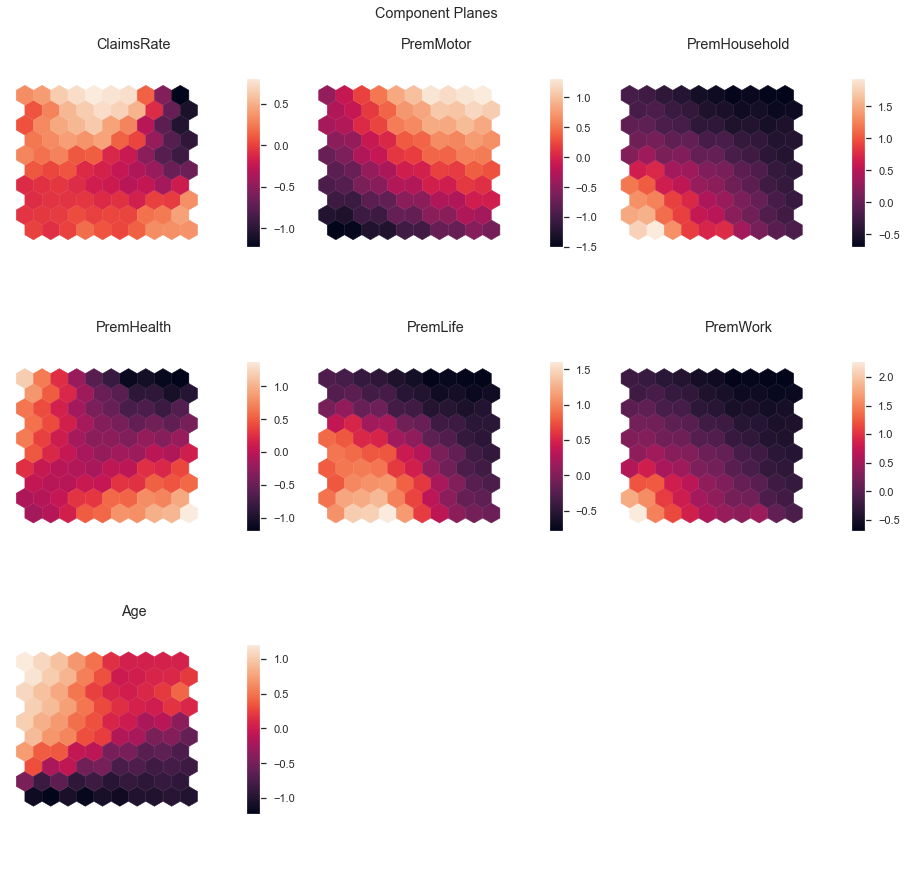

In [181]:
plot_component_planes(weights=sm.codebook.matrix,features=metric_features,
                     M=10,N=10,
                     figsize=(12,12),figlayout=(3,3),
                     title="Component Planes",
                     cmap=sns.color_palette("rocket", as_cmap=True))


In [182]:
# # Here you have U-matrix
# u = sompy.umatrix.UMatrixView(9, 9, 'umatrix', show_axis=True, text_size=8, show_text=True)

# UMAT = u.show(
#     sm, 
#     distance=2,
#     row_normalized=False,
#     show_data=True, 
#     contour=True, # Visualize isomorphic curves
#     blob=True
# )

# np.flip(UMAT[1], axis=1) # U-matrix values - they match with the plot colors

In [183]:
# vhts  = BmuHitsView(12,12,"Hits Map")
# vhts.show(sm, anotate=True, onlyzeros=False, labelsize=12, cmap="Blues")
# plt.show()

## 3. Clustering
> ### 3.1 Split variables into perspectives


In [184]:
#Split variables into perpectives
# demographic=['Age', "EducDeg_b'1 - Basic'", "EducDeg_b'2 - High School'","EducDeg_b'3 - BSc/MSc'","EducDeg_b'4 - PhD'","Children_1", "MonthSal"]
demographic=['Age', "EducDeg_b'1 - Basic'", "EducDeg_b'2 - High School'","EducDeg_b'3 - BSc/MSc'","EducDeg_b'4 - PhD'","Children_1"]

insurance=['ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork']



df_demo=df[demographic].copy()
df_insurance=df[insurance].copy()



#### - Removed geolivArea because almost doesn't have correlations with any other variable

> ### 3.2 Demographic Perspective - K prototypes   

In [185]:
# df_cat_num_demo=df_cat_num[['EducDeg', 'GeoLivArea', 'Children', 'Age', 'MonthSal']].copy()
df_cat_num_demo=df_cat_num[['EducDeg', 'GeoLivArea', 'Children', 'Age']].copy()

In [186]:
df_cat_num_demo

EducDeg  GeoLivArea  Children       Age
CustID                                                    
1       b'2 - High School'           1         1 -0.869210
3             b'1 - Basic'           3         0 -0.159887
4           b'3 - BSc/MSc'           4         1 -0.810100
5           b'3 - BSc/MSc'           4         1 -0.337218
6       b'2 - High School'           4         1  0.667656
...                    ...         ...       ...       ...
10292           b'4 - PhD'           2         0  1.081427
10293         b'1 - Basic'           3         0  0.904097
10294       b'3 - BSc/MSc'           1         1 -0.514549
10295         b'1 - Basic'           2         1 -0.573659
10296           b'4 - PhD'           1         1 -0.810100

[9807 rows x 4 columns]

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 1
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 6
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 9
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 2
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 2
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 1
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 2
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 2
cost (sum distance) for all k:
2 : 9347.252
3 : 7252.889
4 : 6341.923
5 : 5754.377
6 : 5344.351
7 : 4956.789
8 : 4733.536
9 : 4621.610


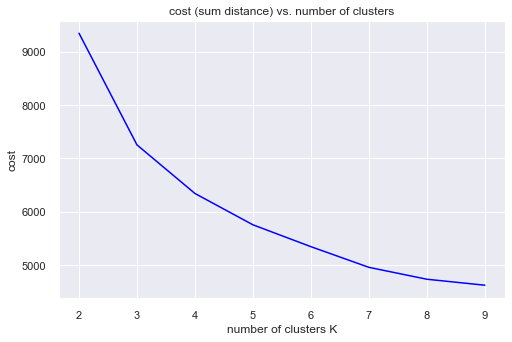

In [187]:
# kprototypes: looking for the elbow - compare number of clusters by their cost
# cost = sum distance of all points to their respective cluster centroids

# run kPrototypes for alternative number of clusters k
dict_cost_c3 = {}
for k in (range(2,10)):
    kproto = KPrototypes(n_clusters=k, init='Cao', n_jobs=-1, verbose=2, random_state=42)
    res = kproto.fit_predict(df_cat_num_demo, categorical=[0,1,2])
    dict_cost_c3[k] = kproto.cost_

print("cost (sum distance) for all k:")
_ = [print(k,":",f'{v:.3f}') for k,v in dict_cost_c3.items()]


# scree plot: look for elbow
plt.figure(figsize=[8,5])
plt.plot(dict_cost_c3.keys(), dict_cost_c3.values(), color="blue")
plt.title("cost (sum distance) vs. number of clusters")
plt.xticks(np.arange(2,10,1))
plt.xlabel("number of clusters K")
plt.ylabel("cost");

In [188]:
# cost (sum distance): confirm visual clue of elbow plot
# KneeLocator class will detect elbows if curve is convex; if concave, will detect knees
cost_knee_c3 = KneeLocator(
        x=list(dict_cost_c3.keys()), 
        y=list(dict_cost_c3.values()), 
        S=0.1, curve="convex", direction="decreasing", online=True)

K_cost_c3 = cost_knee_c3.elbow   
print("elbow at k =", f'{K_cost_c3:.0f} clusters')

elbow at k = 4 clusters


In [189]:
# Fit the cluster
kprototype = KPrototypes(n_clusters = 4, init='Cao', n_jobs=-1, verbose=2, random_state=42)
demo_labels=kprototype.fit_predict(df_cat_num_demo, categorical = [0,1,2])

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 9


In [190]:
# Add the cluster to the dataframe
df_cat_num_demo['Cluster Labels'] = kprototype.labels_
# df_cat_num_demo['Segment'] = df_cat_num_demo['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third'})
df_cat_num_demo['Segment'] = df_cat_num_demo['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third', 3: 'Fourth'})
# df_cat_num_demo['Segment'] = df_cat_num_demo['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third', 3: 'Fourth', 4: 'Fifth'})
# Order the cluster
df_cat_num_demo['Segment'] = df_cat_num_demo['Segment'].astype('category')
# df_cat_num_demo['Segment'] = df_cat_num_demo['Segment'].cat.reorder_categories(['First','Second','Third'])
df_cat_num_demo['Segment'] = df_cat_num_demo['Segment'].cat.reorder_categories(['First','Second','Third', 'Fourth'])
# df_cat_num_demo['Segment'] = df_cat_num_demo['Segment'].cat.reorder_categories(['First','Second','Third', 'Fourth', 'Fifth'])

In [191]:
# Cluster interpretation
df_cat_num_demo.rename(columns = {'Cluster Labels':'Total'}, inplace = True)
df_cat_num_demo.groupby('Segment').agg(
    {
        'Total':'count',
        'EducDeg': lambda x: x.value_counts().index[0],
        'GeoLivArea': lambda x: x.value_counts().index[0],
        'Children': lambda x: x.value_counts().index[0],
        'Age': 'mean',
        # 'MonthSal': 'mean'
    }
).reset_index()

Segment  Total             EducDeg  GeoLivArea  Children       Age
0   First   2584      b'3 - BSc/MSc'           4         1  0.400196
1  Second   1940  b'2 - High School'           1         1 -0.308577
2   Third   2341      b'3 - BSc/MSc'           4         0  1.288679
3  Fourth   2942      b'3 - BSc/MSc'           4         1 -1.167775

In [192]:
df_cat_num_demo

EducDeg  GeoLivArea  Children       Age  Total Segment
CustID                                                                   
1       b'2 - High School'           1         1 -0.869210      1  Second
3             b'1 - Basic'           3         0 -0.159887      1  Second
4           b'3 - BSc/MSc'           4         1 -0.810100      3  Fourth
5           b'3 - BSc/MSc'           4         1 -0.337218      0   First
6       b'2 - High School'           4         1  0.667656      0   First
...                    ...         ...       ...       ...    ...     ...
10292           b'4 - PhD'           2         0  1.081427      2   Third
10293         b'1 - Basic'           3         0  0.904097      2   Third
10294       b'3 - BSc/MSc'           1         1 -0.514549      1  Second
10295         b'1 - Basic'           2         1 -0.573659      1  Second
10296           b'4 - PhD'           1         1 -0.810100      1  Second

[9807 rows x 6 columns]

In [193]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_cat_num_demo)  # get total sum of squares
ssw_labels = df_cat_num_demo.groupby(by='Segment').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.600113790148792

> ### 3.3 Insurance Perspective
>> #### Gaussian Mixture

In [194]:
# from sklearn.mixture import GaussianMixture
# # Performing GMM clustering
# gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
# gmm_labels = gmm.fit_predict(df_insurance)
# labels_proba = gmm.predict_proba(df_insurance)

In [195]:
# # The estimated covariance matrices of the Components
# gmm.covariances_.shape

In [196]:
# # Selecting number of components based on AIC and BIC
# n_components = np.arange(1, 16)
# models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df_insurance)
#           for n in n_components]

# bic_values = [m.bic(df_insurance) for m in models]
# aic_values = [m.aic(df_insurance) for m in models]
# plt.plot(n_components, bic_values, label='BIC')
# plt.plot(n_components, aic_values, label='AIC')
# plt.legend(loc='best')
# plt.xlabel('n_components')
# plt.xticks(n_components)
# plt.show()

In [197]:
# # Performing GMM clustering
# gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=42)
# gmm_labels = gmm.fit_predict(df_insurance)

In [198]:
# # Concatenating the labels to df
# df_concat = pd.concat([df_insurance, pd.Series(gmm_labels, index=df.index, name="gmm_labels")], axis=1)
# df_concat.head()

In [199]:
# # Computing the R^2 of the cluster solution
# sst = get_ss(df_insurance)  # get total sum of squares
# ssw_labels = df_concat.groupby(by='gmm_labels').apply(get_ss)  # compute ssw for each cluster labels
# ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
# r2 = ssb / sst
# print("Cluster solution with R^2 of %0.4f" % r2)

Gaussian has a R^2 of 0.4670


In [200]:
df_insurance

ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  PremWork
CustID                                                                      
1        -0.887023   0.520959      -0.523057   -0.307152  0.355451 -0.454397
3        -1.224518  -0.757756       0.134288   -0.599388  1.508853  1.211024
4         0.953859  -0.936113      -0.686656    1.904210  0.013300 -0.222215
5         0.677726   0.240425      -0.666489    0.178969 -0.472219  0.043627
6         0.984540   1.009990      -0.797460   -0.730613 -0.817595 -0.641359
...            ...        ...            ...         ...       ...       ...
10292     0.861814   0.655762      -0.659012    0.061162 -0.736089 -0.497183
10293    -2.083597  -1.304581       3.810748   -0.348881 -0.644907  1.334922
10294    -1.439288   0.730285      -0.281283   -0.362298 -0.651357 -0.697731
10295    -0.089308  -0.890073       0.073788    0.390700  0.850646  1.492683
10296    -1.255200   0.809027      -0.455079   -0.375716 -0.820820 -0.535508

[9807 rows x 6 columns]

>> ### K-Means

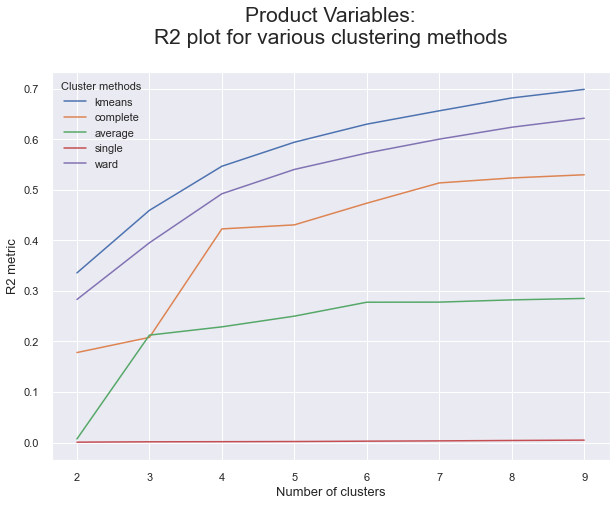

In [201]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust
    
# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    metric='euclidean'
)

# Obtaining the R² scores for each cluster solution on product variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_insurance, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_insurance, hierarchical.set_params(linkage=linkage)
    )

# Visualizing the R² scores for each cluster solution on product variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Product Variables:\nR2 plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)
plt.show()

silhouette scores:
2 : 0.301
3 : 0.258
4 : 0.281
5 : 0.278
6 : 0.263
7 : 0.247
8 : 0.250
9 : 0.250
maximum silhouette score for 2 clusters:  0.301


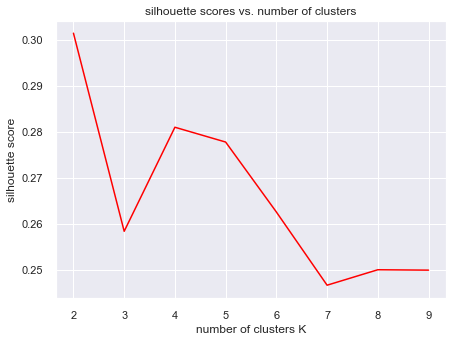

In [202]:
# find maximum silhouette score for up to 10 clusters
sil_scores = [silhouette_score(
                                df_insurance, 
                                KMeans(init='k-means++',n_clusters=k, random_state=42, n_init=20). \
                                fit_predict(df_insurance)) \
                                for k in (range(2,10))]

dict_sil = dict(zip(range(2,10), sil_scores))
print("silhouette scores:")
_ = [print(k, ":", f'{v:,.3f}') for k,v in dict_sil.items()]
K_sil_b3 = max(dict_sil, key=dict_sil.get)            # optimal clusters
sil_opt_b3 = dict_sil[K_sil_b3]                       # optimal silhouette score
print("maximum silhouette score for", f'{K_sil_b3:.0f} clusters: ', f'{sil_opt_b3:.3f}')

plt.figure(figsize=[7,5])
plt.plot(range(2,10), sil_scores, color="red")
plt.title("silhouette scores vs. number of clusters")
plt.xticks(np.arange(2,10,1))
plt.xlabel("number of clusters K")
plt.ylabel("silhouette score")
plt.show()

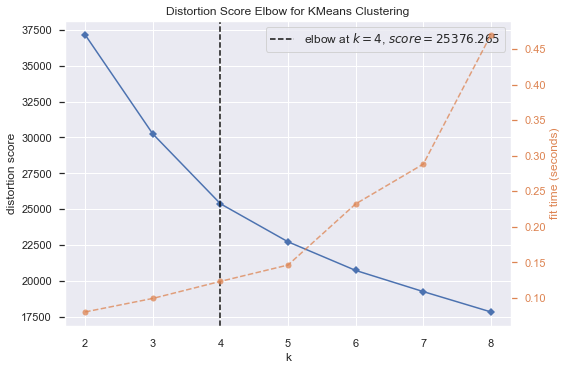

In [203]:
fig, ax = plt.subplots()

visualizer = KElbowVisualizer(KMeans(init='k-means++', n_init=20, random_state=42), k=(2,9),ax=ax)
visualizer.fit(df_insurance)

ax.set_xticks(range(2,9))
visualizer.show()
plt.show()

> ### 3.4 Merging Perspectives

In [204]:
demo_labels

array([1, 1, 3, ..., 1, 1, 1], dtype=uint16)

In [205]:
df_cat_num

EducDeg  GeoLivArea  Children  ClaimsRate  PremMotor  \
CustID                                                                    
1       b'2 - High School'           1         1   -0.887023   0.520959   
3             b'1 - Basic'           3         0   -1.224518  -0.757756   
4           b'3 - BSc/MSc'           4         1    0.953859  -0.936113   
5           b'3 - BSc/MSc'           4         1    0.677726   0.240425   
6       b'2 - High School'           4         1    0.984540   1.009990   
...                    ...         ...       ...         ...        ...   
10292           b'4 - PhD'           2         0    0.861814   0.655762   
10293         b'1 - Basic'           3         0   -2.083597  -1.304581   
10294       b'3 - BSc/MSc'           1         1   -1.439288   0.730285   
10295         b'1 - Basic'           2         1   -0.089308  -0.890073   
10296           b'4 - PhD'           1         1   -1.255200   0.809027   

        PremHousehold  PremHealth  PremLife  PremWork       Age  
CustID                                                           
1           -0.523057   -0.307152  0.355451 -0.454397 -0.869210  
3            0.134288   -0.599388  1.508853  1.211024 -0.159887  
4           -0.686656    1.904210  0.013300 -0.222215 -0.810100  
5           -0.666489    0.178969 -0.472219  0.043627 -0.337218  
6           -0.797460   -0.730613 -0.817595 -0.641359  0.667656  
...               ...         ...       ...       ...       ...  
10292       -0.659012    0.061162 -0.736089 -0.497183  1.081427  
10293        3.810748   -0.348881 -0.644907  1.334922  0.904097  
10294       -0.281283   -0.362298 -0.651357 -0.697731 -0.514549  
10295        0.073788    0.390700  0.850646  1.492683 -0.573659  
10296       -0.455079   -0.375716 -0.820820 -0.535508 -0.810100  

[9807 rows x 10 columns]

In [206]:
# Applying the right clustering (algorithm and number of clusters) for each perspective
kmeans_insurance = KMeans(init='k-means++', n_init=20, random_state=42, n_clusters=4)
insurance_labels = kmeans_insurance.fit_predict(df_insurance)



df_cat_num['insurance_labels'] = insurance_labels
df_cat_num['demo_labels'] = demo_labels
df=df_cat_num.copy()

In [207]:
# Count label frequencies (contigency table)
df.groupby(['insurance_labels', 'demo_labels'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('demo_labels', 'insurance_labels', 0)

insurance_labels    0    1     2    3
demo_labels                          
0                 963  937   468  216
1                 613  600   519  208
2                 328  339  1320  354
3                 407  479  1125  931

merging small clusters using hierarchical

In [208]:
# Centroids of the concatenated cluster labels
df_centroids = df.groupby(['demo_labels', 'insurance_labels'])\
    [metric_features].mean()
df_centroids

ClaimsRate  PremMotor  PremHousehold  \
demo_labels insurance_labels                                         
0           0                   0.903105   1.030147      -0.541471   
            1                  -1.266988   0.974143      -0.495532   
            2                   0.195413  -0.342577       0.014974   
            3                  -0.147262  -0.751417       1.118592   
1           0                   0.922677   0.965592      -0.572608   
            1                  -1.206570   0.912071      -0.550769   
            2                   0.242394  -0.452628      -0.084114   
            3                   0.065574  -0.895371       1.271834   
2           0                   0.885106   0.680180      -0.516505   
            1                  -1.058169   0.565118      -0.452614   
            2                   0.235264  -0.608737      -0.045893   
            3                  -0.151191  -1.137903       1.295979   
3           0                   0.913453   0.747788      -0.569923   
            1                  -1.127350   0.642922      -0.460686   
            2                   0.215569  -0.635276      -0.024629   
            3                  -0.035195  -1.470175       1.692554   

                              PremHealth  PremLife  PremWork       Age  
demo_labels insurance_labels                                            
0           0                  -0.916841 -0.614225 -0.484027  0.345097  
            1                  -0.880729 -0.562038 -0.465574  0.342140  
            2                   0.448281  0.210100  0.094661  0.554235  
            3                  -0.371768  1.203542  0.790742  0.563939  
1           0                  -0.798453 -0.604028 -0.490085 -0.224108  
            1                  -0.747679 -0.569887 -0.457773 -0.215648  
            2                   0.746999  0.169712  0.040768 -0.477648  
            3                  -0.216243  1.179079  0.778645 -0.403717  
2           0                  -0.392774 -0.521557 -0.441788  1.272635  
            1                  -0.271995 -0.459349 -0.396683  1.271487  
            2                   1.070211  0.108876 -0.027516  1.307435  
            3                   0.245490  1.104874  0.797578  1.250075  
3           0                  -0.403151 -0.609041 -0.480529 -0.854251  
            1                  -0.346420 -0.522484 -0.443498 -0.896729  
            2                   1.068331  0.101482  0.047003 -1.129453  
            3                   0.046034  1.402565  1.420003 -1.490598

In [209]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

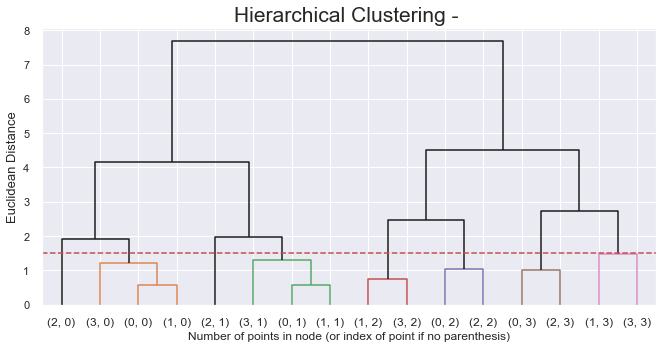

In [212]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 1.5
dendrogram(linkage_matrix, truncate_mode='level', labels=df_centroids.index, p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [213]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=6
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

ClaimsRate  PremMotor  PremHousehold  \
demo_labels insurance_labels                                         
0           0                   0.903105   1.030147      -0.541471   
            1                  -1.266988   0.974143      -0.495532   
            2                   0.195413  -0.342577       0.014974   
            3                  -0.147262  -0.751417       1.118592   
1           0                   0.922677   0.965592      -0.572608   
            1                  -1.206570   0.912071      -0.550769   
            2                   0.242394  -0.452628      -0.084114   
            3                   0.065574  -0.895371       1.271834   
2           0                   0.885106   0.680180      -0.516505   
            1                  -1.058169   0.565118      -0.452614   
            2                   0.235264  -0.608737      -0.045893   
            3                  -0.151191  -1.137903       1.295979   
3           0                   0.913453   0.747788      -0.569923   
            1                  -1.127350   0.642922      -0.460686   
            2                   0.215569  -0.635276      -0.024629   
            3                  -0.035195  -1.470175       1.692554   

                              PremHealth  PremLife  PremWork       Age  \
demo_labels insurance_labels                                             
0           0                  -0.916841 -0.614225 -0.484027  0.345097   
            1                  -0.880729 -0.562038 -0.465574  0.342140   
            2                   0.448281  0.210100  0.094661  0.554235   
            3                  -0.371768  1.203542  0.790742  0.563939   
1           0                  -0.798453 -0.604028 -0.490085 -0.224108   
            1                  -0.747679 -0.569887 -0.457773 -0.215648   
            2                   0.746999  0.169712  0.040768 -0.477648   
            3                  -0.216243  1.179079  0.778645 -0.403717   
2           0                  -0.392774 -0.521557 -0.441788  1.272635   
            1                  -0.271995 -0.459349 -0.396683  1.271487   
            2                   1.070211  0.108876 -0.027516  1.307435   
            3                   0.245490  1.104874  0.797578  1.250075   
3           0                  -0.403151 -0.609041 -0.480529 -0.854251   
            1                  -0.346420 -0.522484 -0.443498 -0.896729   
            2                   1.068331  0.101482  0.047003 -1.129453   
            3                   0.046034  1.402565  1.420003 -1.490598   

                              hclust_labels  
demo_labels insurance_labels                 
0           0                             1  
            1                             0  
            2                             3  
            3                             4  
1           0                             1  
            1                             0  
            2                             5  
            3                             2  
2           0                             1  
            1                             0  
            2                             3  
            3                             4  
3           0                             1  
            1                             0  
            2                             5  
            3                             2

In [214]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_ = df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['demo_labels'], row['insurance_labels'])
    ], axis=1
)

# Merged cluster centroids
df_.groupby('merged_labels').mean()[metric_features]

ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  \
merged_labels                                                               
0               -1.193134   0.832080      -0.496340   -0.650527 -0.541211   
1                0.907564   0.913625      -0.551197   -0.720589 -0.597455   
2               -0.016793  -1.365206       1.615723   -0.001862  1.361753   
3                0.224833  -0.539071      -0.029962    0.907424  0.135371   
4               -0.149702  -0.991445       1.228759    0.011581  1.142264   
5                0.224038  -0.577615      -0.043408    0.966889  0.123021   

               PremWork       Age  
merged_labels                      
0             -0.449179  0.081825  
1             -0.479023  0.114537  
2              1.302881 -1.292116  
3              0.004463  1.110288  
4              0.794987  0.990066  
5              0.045035 -0.923682

In [215]:
#Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts['demo_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['insurance_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])
df_counts.pivot('demo_labels', 'insurance_labels', 0)

insurance_labels       0       1       2       3
demo_labels                                     
2                    NaN     NaN  1788.0   570.0
3                 2311.0  2355.0  1644.0  1139.0

In [216]:
# Setting df to have the final product, behavior and merged clusters
df = df_.copy()

In [326]:
df

EducDeg  MonthSal  GeoLivArea  Children  ClaimsRate  \
CustID                                                                   
1       b'2 - High School' -0.289077           1         1   -0.120238   
2       b'2 - High School' -1.587974           4         1    0.130769   
3             b'1 - Basic' -0.202484           3         0   -0.158061   
4           b'3 - BSc/MSc' -1.222551           4         1    0.086069   
5           b'3 - BSc/MSc' -0.647572           4         1    0.055123   
...                    ...       ...         ...       ...         ...   
10292           b'4 - PhD'  0.586380           2         0    0.075754   
10293         b'1 - Basic' -0.069130           3         0   -0.254337   
10294       b'3 - BSc/MSc'  0.352578           1         1   -0.182130   
10295         b'1 - Basic' -0.467459           2         1   -0.030838   
10296           b'4 - PhD'  0.263387           1         1   -0.161499   

        PremMotor  PremHousehold  PremHealth  PremLife  PremWork       Age  \
CustID                                                                       
1        0.365331      -0.368141   -0.085775  0.133284 -0.474537 -0.715852   
2       -1.092446       0.588024   -0.188780  3.328255  1.295093 -1.376860   
3       -0.463734       0.043713   -0.161388  0.985594  1.154102 -0.105692   
4       -0.579373      -0.470643    0.486393 -0.119549 -0.247484 -0.665006   
5        0.183445      -0.458008    0.040004 -0.478325  0.012488 -0.258232   
...           ...            ...         ...       ...       ...       ...   
10292    0.452732      -0.453323    0.009523 -0.673312 -0.516379  0.962090   
10293   -0.818273       2.347170   -0.096572 -0.605933  1.275263  0.809550   
10294    0.501049      -0.216659   -0.100044 -0.610699 -0.712498 -0.410772   
10295   -0.549523       0.005807    0.094787  0.499210  1.429541 -0.461619   
10296    0.552103      -0.325550   -0.103515 -0.735924 -0.553857 -0.665006   

        insurance_labels  demo_labels  merged_labels  
CustID                                                
1                      3            3              7  
2                      2            1              0  
3                      1            3              2  
4                      0            1              6  
5                      3            3              7  
...                  ...          ...            ...  
10292                  3            2              1  
10293                  1            0              4  
10294                  3            3              7  
10295                  1            3              2  
10296                  3            3              7  

[10212 rows x 14 columns]

> ### 3.5 Profiling

In [217]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profiling", fontsize=23)
    plt.show()

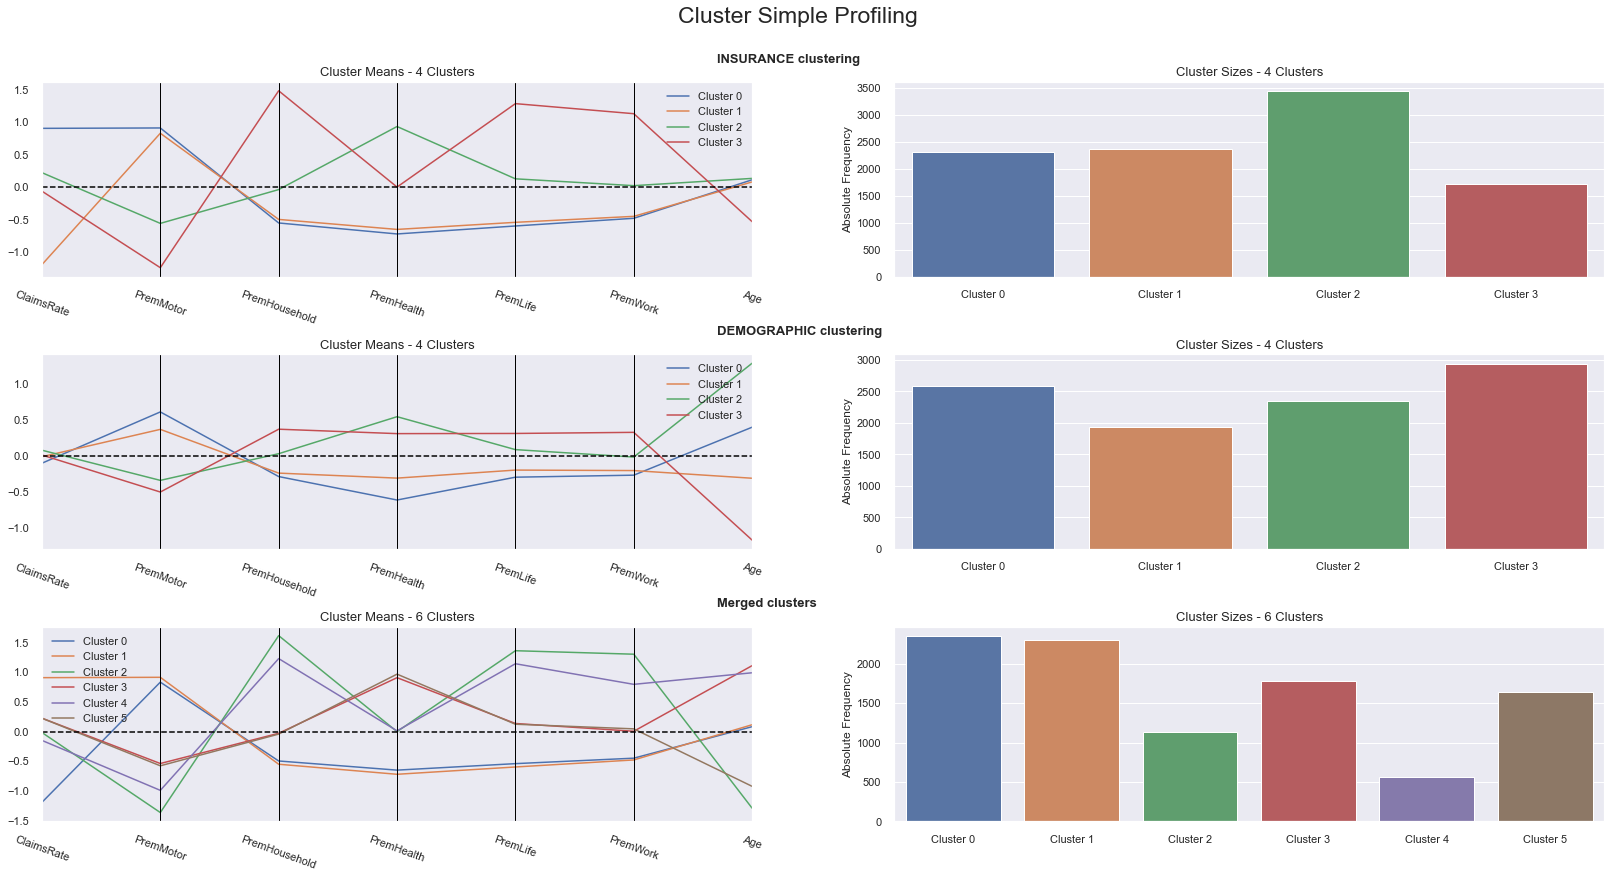

In [218]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df[metric_features + ['insurance_labels', 'demo_labels', 'merged_labels']], 
    label_columns = ['insurance_labels', 'demo_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compar_titles = ["INSURANCE clustering", "DEMOGRAPHIC clustering", "Merged clusters"]
)

In [219]:
# Characterizing the final clusters
df_means = df.groupby('merged_labels').mean().copy()
df_means= df_means[metric_features]
df_means

ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  \
merged_labels                                                               
0               -1.193134   0.832080      -0.496340   -0.650527 -0.541211   
1                0.907564   0.913625      -0.551197   -0.720589 -0.597455   
2               -0.016793  -1.365206       1.615723   -0.001862  1.361753   
3                0.224833  -0.539071      -0.029962    0.907424  0.135371   
4               -0.149702  -0.991445       1.228759    0.011581  1.142264   
5                0.224038  -0.577615      -0.043408    0.966889  0.123021   

               PremWork       Age  
merged_labels                      
0             -0.449179  0.081825  
1             -0.479023  0.114537  
2              1.302881 -1.292116  
3              0.004463  1.110288  
4              0.794987  0.990066  
5              0.045035 -0.923682

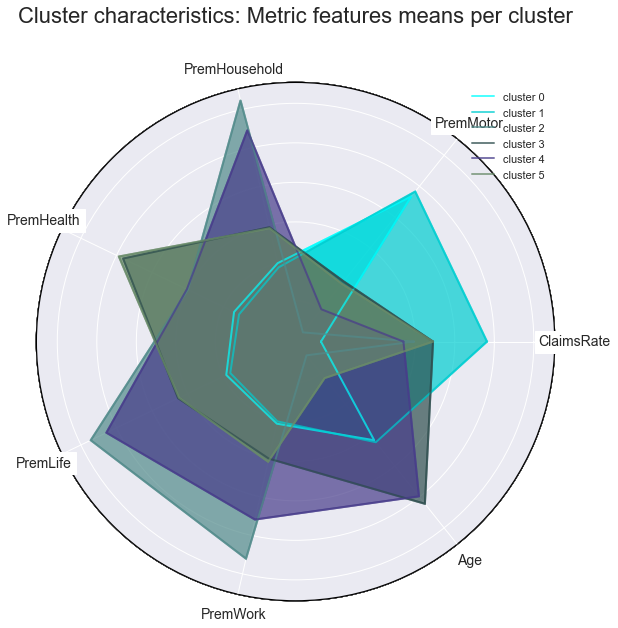

In [220]:
cluster_colors = ['#00FFFF', '#00CED1', '#528B8B', '#2F4F4F', '#483D8B', '#698B69', '#B4EEB4', '#8FBC8F']

class Radar(object):
    def __init__(self, figure, title, labels, rect=None):
        if rect is None:
            rect = [0.05, 0.05, 0.9, 0.9]

        self.n = len(title)
        self.angles = np.arange(0, 360, 360.0/self.n)
        
        self.axes = [figure.add_axes(rect, projection='polar', label='axes%d' % i) for i in range(self.n)]
        self.ax = self.axes[0]
        self.ax.set_thetagrids(self.angles, labels=title, fontsize=14, backgroundcolor="white",zorder=999) # Feature names
        self.ax.set_yticklabels([])
        
        for ax in self.axes[1:]:
            ax.xaxis.set_visible(False)
            ax.set_yticklabels([])
            ax.set_zorder(-99)

        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.spines['polar'].set_color('black')
            ax.spines['polar'].set_zorder(-99)
                     
    def plot(self, values, *args, **kw):
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = np.r_[values, values[0]]
        self.ax.plot(angle, values, *args, **kw)
        kw['label'] = '_noLabel'
        self.ax.fill(angle, values,*args,**kw)

fig = plt.figure(figsize=(8, 8))
no_features = len(metric_features)
radar = Radar(fig, metric_features, np.unique(df['merged_labels']))

for k in range(0,len(np.unique(df['merged_labels']))):
    cluster_data = df_means.T[k].values.tolist()
    radar.plot(cluster_data,  '-', lw=2, color=cluster_colors[k], alpha=0.7, label='cluster {}'.format(k))

radar.ax.legend()
radar.ax.set_title("Cluster characteristics: Metric features means per cluster", size=22, pad=60)
plt.show()

In [221]:
# helper function: pie charts for categorical variables
def cluster_pies(df):
    
    # number of categorical variables
    c = 3
    
    # number of clusters
    K = df["merged_labels"].nunique()

    for k in (range(K)):
        dfc = df[df["merged_labels"]==k]
        # chrg = dfc["MonthlyCharges"].median()
        # ten = dfc["tenure"].median()
        cases = dfc.shape[0]

        fig = plt.figure(figsize=(50, 12))
        fig.suptitle("Cluster " + str(k) + ": " + \
            f'{cases:,.0f}' + " cases")


        ax1 = plt.subplot2grid((2,c),(0,0))
        plt.pie(dfc["EducDeg"].value_counts(), labels=dfc["EducDeg"].unique(), autopct='%1.1f%%')
        plt.title("EducDeg");

        ax1 = plt.subplot2grid((2,c),(0,1))
        plt.pie(dfc["Children"].value_counts(), labels=dfc["Children"].unique(), autopct='%1.1f%%')
        plt.title("Children");

        ax1 = plt.subplot2grid((2,c),(0,2))
        plt.pie(dfc["GeoLivArea"].value_counts(), labels=dfc["GeoLivArea"].unique(), autopct='%1.1f%%')
        plt.title("GeoLivArea");

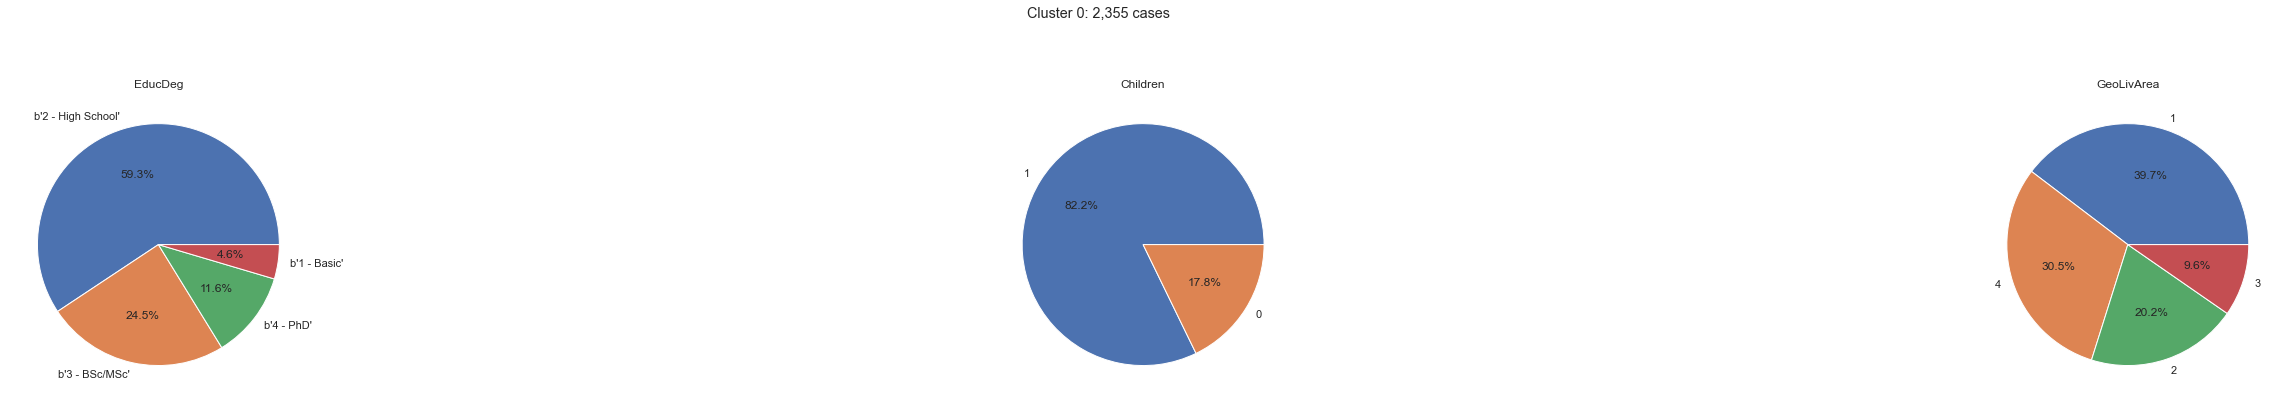

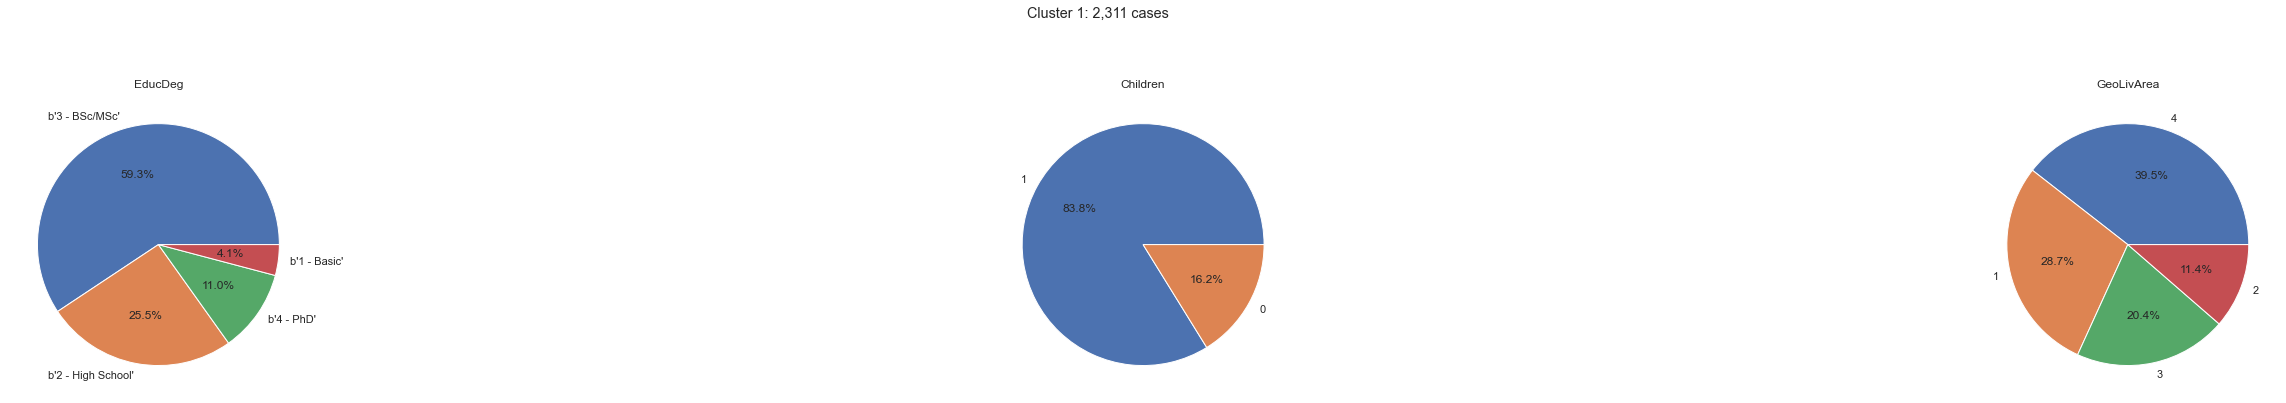

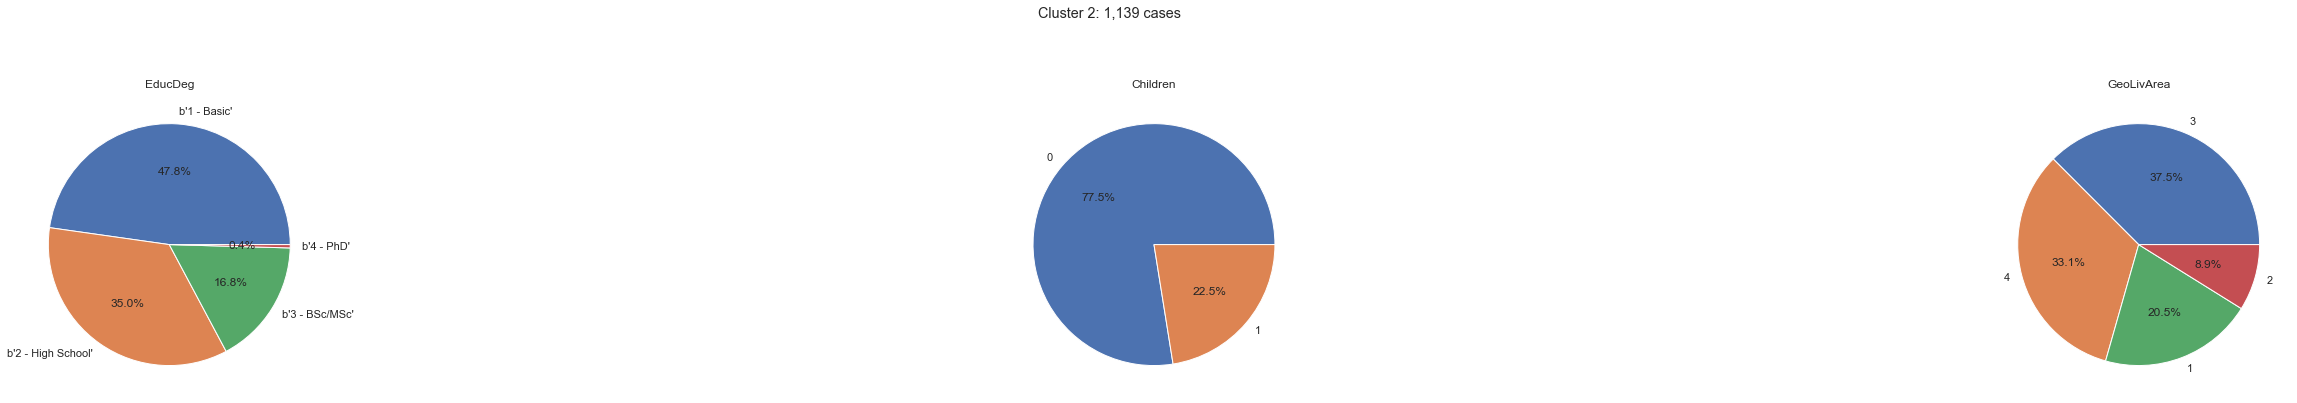

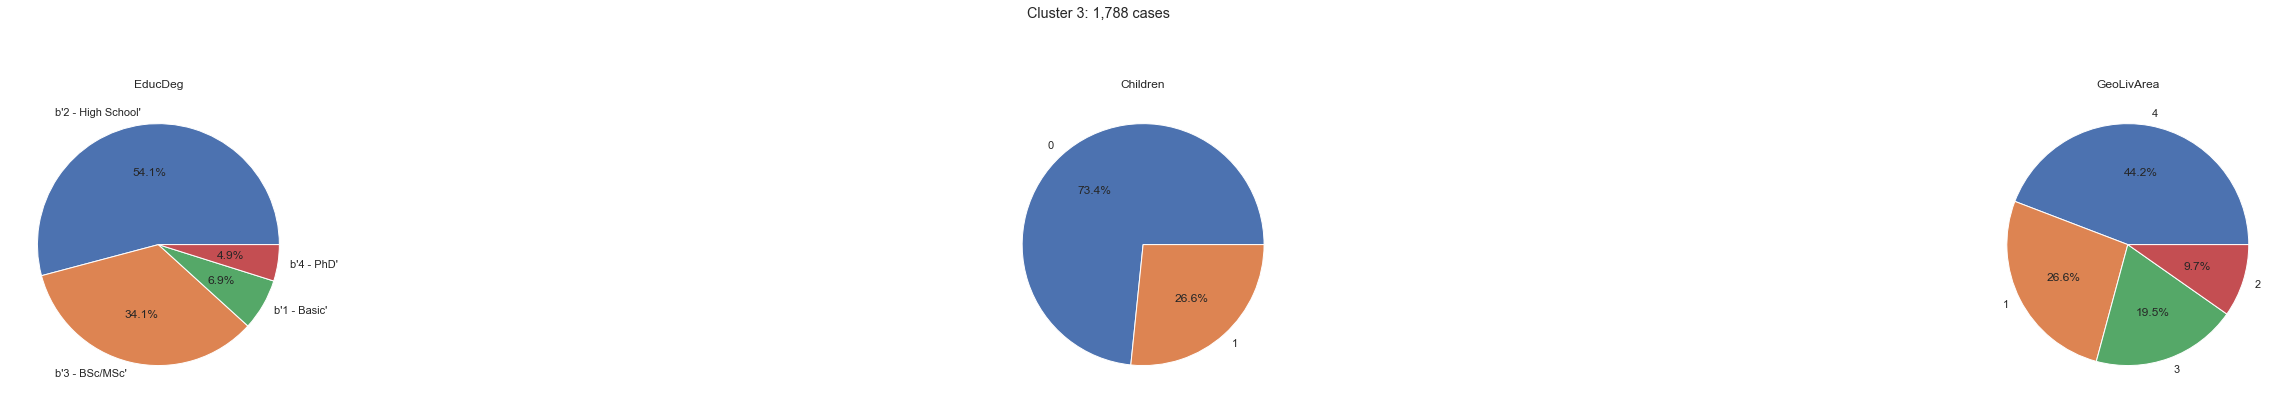

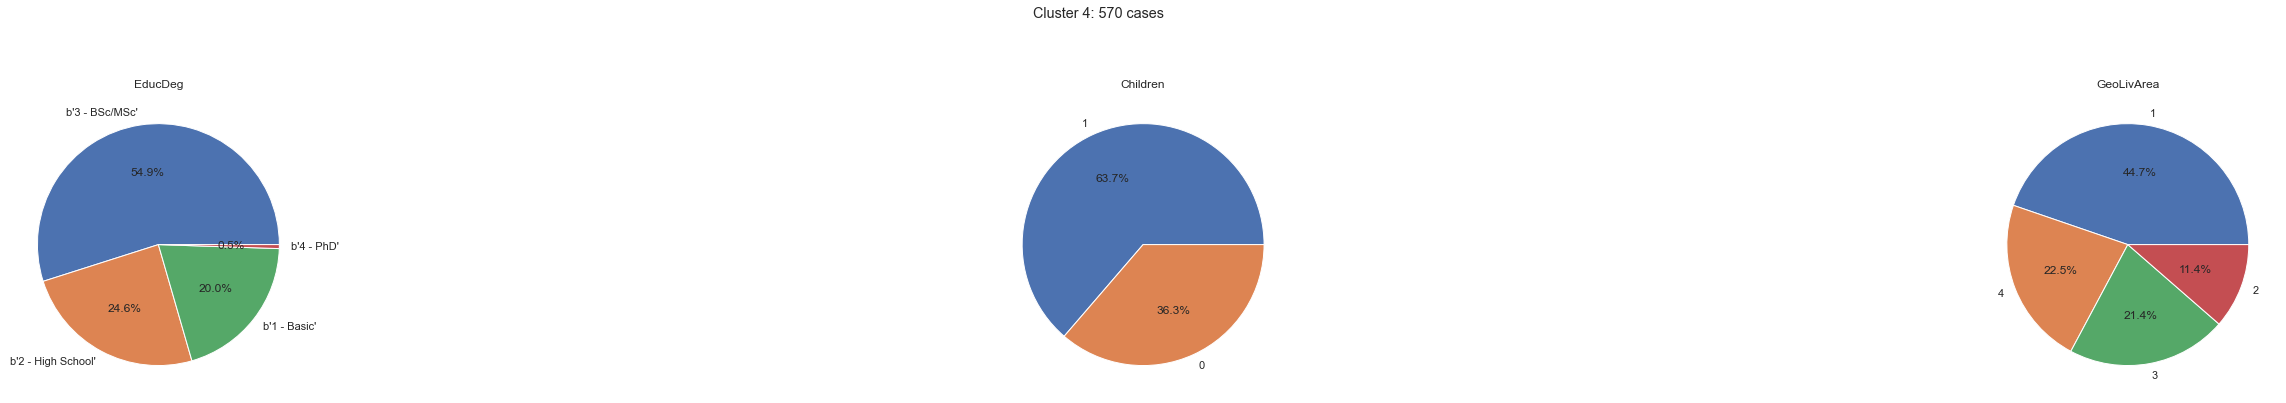

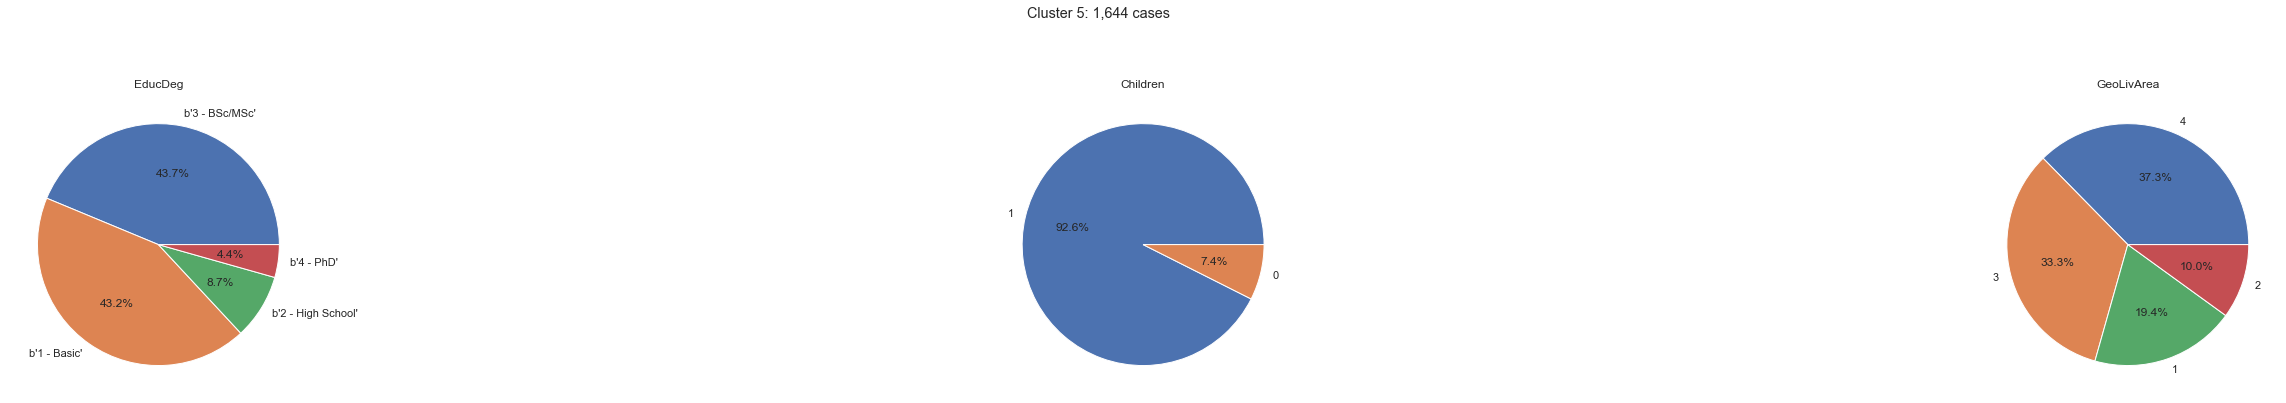

In [222]:
cluster_pies(df)

## 4. Visualization 

> ### 4.1 T-SNE

In [333]:
two_dim = TSNE(random_state=42, perplexity=300).fit_transform(df[metric_features])

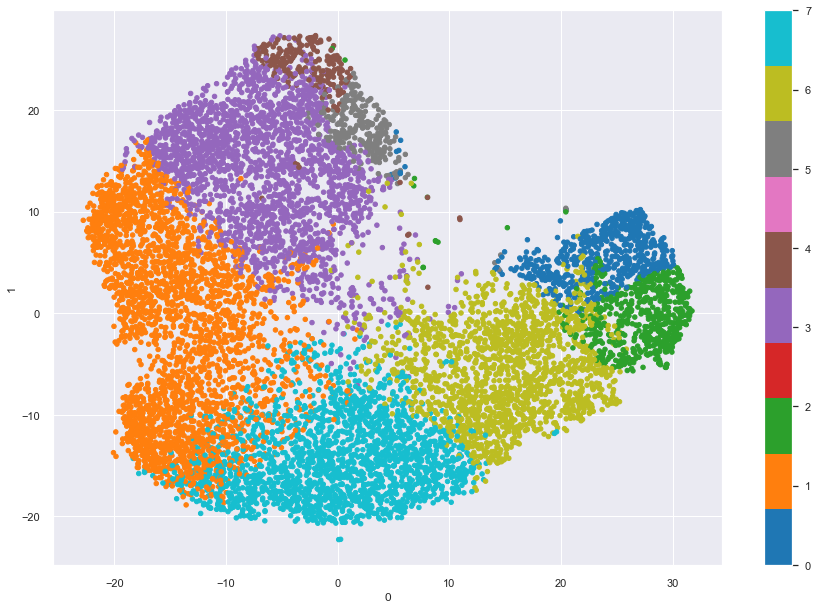

In [334]:
# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['merged_labels'], colormap='tab10', figsize=(15,10))
plt.show()

### Feature Importance

In [223]:
def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars

def r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars


In [224]:
# We are essentially decomposing the R² into the R² for each variable
r2_variables(df[metric_features + ['merged_labels']], 'merged_labels').drop('merged_labels')

ClaimsRate       0.584815
PremMotor        0.749299
PremHousehold    0.529435
PremHealth       0.530641
PremLife         0.452377
PremWork         0.433597
Age              0.625141
dtype: float64

In [225]:
# Preparing the data
X = df[metric_features]
y = df.merged_labels

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=8
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=9)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 90.90% of the customers correctly


> ### 4.2 UMAP

In [226]:
def chart(X, y):
    #--------------------------------------------------------------------------#
    # This section is not mandatory as its purpose is to sort the data by label 
    # so, we can maintain consistent colors for digits across multiple graphs
    
    # Concatenate X and y arrays
    arr_concat=pd.concat([pd.DataFrame(X, index=y.index),y],axis=1)
    arr_concat.columns = ['x', 'y', 'z', 'label']
    # Create a Pandas dataframe using the above array
    df=arr_concat.copy()
    # Convert label data type from float to integer
    # df['label'] = int(df['label'])
    # Finally, sort the dataframe by label
    df.sort_values(by='label', axis=0, ascending=True, inplace=True)
    #--------------------------------------------------------------------------#
    
    # Create a 3D graph
    fig = px.scatter_3d(df, x='x', y='y', z='z', color=df['label'].astype(str), height=900, width=950)

    # Update chart looks
    fig.update_layout(title_text='UMAP',
                      showlegend=True,
                      legend=dict(orientation="h", yanchor="top", y=0, xanchor="center", x=0.5),
                      scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                            center=dict(x=0, y=0, z=-0.1),
                                            eye=dict(x=1.5, y=-1.4, z=0.5)),
                                            margin=dict(l=0, r=0, b=0, t=0),
                      scene = dict(xaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             ),
                                   yaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                              ),
                                   zaxis=dict(backgroundcolor='lightgrey',
                                              color='black', 
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             )))
    # Update marker size
    fig.update_traces(marker=dict(size=3, line=dict(color='black', width=0.1)))
    
    fig.show()

> #### UMAP all data

In [227]:
# Configure UMAP hyperparameters
reducer = UMAP.UMAP(n_neighbors=100, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
               n_components=3, # default 2, The dimension of the space to embed into.
               n_epochs=1000, # default None, The number of training epochs to be used in optimizing the low dimensional embedding. Larger values result in more accurate embeddings. 
               random_state=42, # default: None, If int, random_state is the seed used by the random number generator;
              )

# Fit and transform the data
X_trans = reducer.fit_transform(X)

# Check the shape of the new data
print('Shape of X_trans: ', X_trans.shape)

Shape of X_trans:  (9807, 3)


In [228]:
chart(X_trans, y)

> #### UMAP train test data

In [229]:
# Configure UMAP hyperparameters
reducer2 = UMAP.UMAP(n_neighbors=100, n_components=3, n_epochs=1000, 
                min_dist=0.8, random_state=42, local_connectivity=4
              )

# Training on MNIST digits data - this time we also pass the true labels to a fit_transform method
X_train_res = reducer2.fit_transform(X_train, y_train)

# Apply on a test set
X_test_res = reducer2.transform(X_test)

# Print the shape of new arrays
print('Shape of X_train_res: ', X_train_res.shape)
print('Shape of X_test_res: ', X_test_res.shape)

Shape of X_train_res:  (8335, 3)
Shape of X_test_res:  (1472, 3)


In [230]:
chart(X_train_res, y_train)

In [231]:
#To check if UMAP could successfully place new data points into these clusters
chart(X_test_res, y_test)

### Predicting cluster labels of the outliers from DBSCAN

In [232]:
df_out['merged_labels'] = dt.predict(df_out[metric_features])
df_out.head()

ClaimsRate  PremMotor  PremHousehold  PremHealth  PremLife  PremWork  \
CustID                                                                         
150      -0.150671  -1.822095       0.010795   -1.874332 -0.478669  8.359173   
952      15.097968   1.468880      -0.973749   -1.057198 -1.052145 -0.837446   
1026     11.293479   0.477406      -0.817627    0.272893 -0.589494 -0.319144   
1746     -0.334759  -2.097580       4.659336   -0.836478  0.902833  9.222401   
1776      2.273157  -2.028935      -0.324108   -1.347958  0.563908  7.660600   

             Age  EducDeg_b'1 - Basic'  EducDeg_b'2 - High School'  \
CustID                                                               
150    -1.578533                   1.0                         0.0   
952    -0.514549                   0.0                         0.0   
1026    1.672530                   0.0                         0.0   
1746   -1.874084                   1.0                         0.0   
1776   -1.519423                   0.0                         1.0   

        EducDeg_b'3 - BSc/MSc'  EducDeg_b'4 - PhD'  Children_1  GeoLivArea_1  \
CustID                                                                         
150                        0.0                 0.0         1.0           0.0   
952                        1.0                 0.0         1.0           0.0   
1026                       1.0                 0.0         1.0           1.0   
1746                       0.0                 0.0         1.0           0.0   
1776                       0.0                 0.0         0.0           0.0   

        GeoLivArea_2  GeoLivArea_3  GeoLivArea_4  merged_labels  
CustID                                                           
150              0.0           0.0           1.0              0  
952              0.0           1.0           0.0              1  
1026             0.0           0.0           0.0              1  
1746             0.0           0.0           1.0              2  
1776             0.0           1.0           0.0              2

In [345]:
out_labels=pd.DataFrame(df_out.merged_labels.value_counts())
out_labels.columns=[ '#']
out_labels.index.name = 'Cluster'
out_labels

#
Cluster    
1        10
2         5
6         5
3         3
7         2
4         1

### Decision Tree

In [346]:
# # Visualizing the decision tree
# dot_data = export_graphviz(dt, out_file=None, 
#                            feature_names=X.columns.to_list(),
#                            filled=True,
#                            rounded=True,
#                            special_characters=True)  
# graphviz.Source(dot_data)